# SSAM analysis of mouse SSp, imaged by osmFISH
- Author: Jeongbin Park
- Date: 2019-10-13

Set plot parametes / define helper functions

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_scalebar.scalebar import ScaleBar

from sklearn import preprocessing
import pickle

In [2]:
## Parameters for post-filtering of cell type maps
filter_method = "local"
filter_params = {
    "block_size": 151,
    "method": "mean",
    "mode": "constant",
    "offset": 0.3
}

In [3]:
def load_tsne(tsne_id):
    with open("zenodo/osmFISH/tsne/%s.pkl"%tsne_id, "rb") as f:
        ds.tsne = pickle.load(f)

In [4]:
def shorten_labels(lbls):
    l = []
    for lbl in lbls:
        lbl = lbl[0].capitalize() + lbl[1:]
        l.append(lbl
                 .replace("Oligodendrocyte Precursor cells", "OPC")
                 .replace("Oligodendrocyte", "OD")
                 .replace("Vascular Smooth Muscle", "VSM")
                 .replace("Astrocyte", "Astro.")
                 .replace("Perivascular Macrophages", "PVM")
                 .replace("Pyramidal", "Py.")
                 .replace("Inhibitory", "Inhib.")
                )
    return l

In [5]:
width_cutoff = 1640 # um

## Load data

Load mRNA spot locations

In [6]:
import numpy as np
import h5py
from collections import OrderedDict

pixel_per_um = 15.3846 # from BioRxiv paper
um_per_pixel = 1.0 / pixel_per_um
f = h5py.File("zenodo/osmFISH/raw_data/mRNA_coords_raw_counting.hdf5", 'r')
keys = list(f.keys())

pos_dic = OrderedDict()
genes = []

# Exclude bad quality data, according to the supplementary material of osmFISH paper
blacklists = ['Cnr1_Hybridization4', 'Plp1_Hybridization4', 'Vtn_Hybridization4',
              'Klk6_Hybridization5', 'Lum_Hybridization9', 'Tbr1_Hybridization11']

for k in keys:
    if k in blacklists:
        continue
    gene = k.split("_")[0]
    
    # Correct wrong gene labels
    if gene == 'Tmem6':
        gene = 'Tmem2'
    elif gene == 'Kcnip':
        gene = 'Kcnip2'
    
    points = np.array(f[k]) * um_per_pixel
    if gene in pos_dic:
        pos_dic[gene] = np.vstack((pos_dic[gene], points))
    else:
        pos_dic[gene] = points
        genes.append(gene)
genes = sorted(genes)

## SSAM analysis
### Run KDE and select representative vectors

Initilize SSAM and run KDE

In [7]:
import ssam

/icgc/dkfzlsdf/analysis/B260/users/parkj/miniconda3/envs/oldssam/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [8]:
width, height = 2080, 3380 # um

In [9]:
all_genes = list(pos_dic.keys())
mrna_loci = [pos_dic[gene] for gene in all_genes]

ds = ssam.SSAMDataset(all_genes, mrna_loci, width, height)
analysis = ssam.SSAMAnalysis(ds, ncores=10,
                             save_dir="zenodo/osmFISH/kde",
                             verbose=True)

analysis.run_kde(bandwidth=2.5, use_mmap=False)

In [10]:
# Cut off the excluded region from the image
# (the region was used for testing stripping efficiency) 

ds.vf = ds.vf[:width_cutoff, ...]
ds.shape = (1640, ds.shape[1], ds.shape[2], )

Select local maxima of gene expression in the vector field

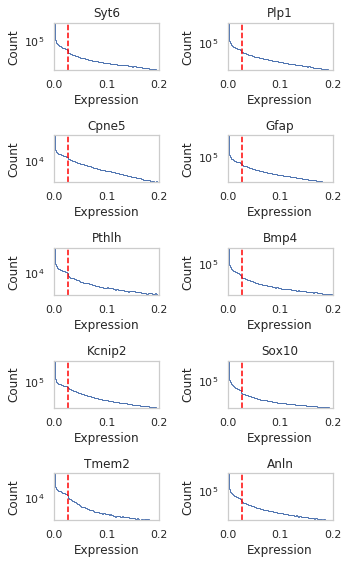

In [11]:
exp_thres = 0.027
viewport = 0.2
gindices = np.arange(len(ds.genes))
np.random.shuffle(gindices)
plt.figure(figsize=[5, 8])
for i, gidx in enumerate(gindices[:10], start=1):
    ax = plt.subplot(5, 2, i)
    n, bins, patches = ax.hist(ds.vf[..., gidx][np.logical_and(ds.vf[..., gidx] > 0, ds.vf[..., gidx] < viewport)], bins=100, log=True, histtype=u'step')
    ax.set_xlim([0, viewport])
    ax.set_ylim([n[0], n[-1]])
    ax.axvline(exp_thres, c='red', ls='--')
    ax.set_title(ds.genes[gidx])
    ax.set_xlabel("Expression")
    ax.set_ylabel("Count")
plt.tight_layout()
pass

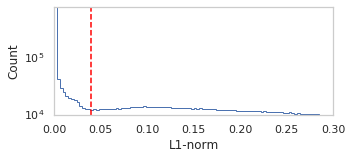

In [12]:
gidx = 0
norm_thres = 0.04
plt.figure(figsize=[5, 2])
#plt.hist(ds.vf[..., gidx][ds.vf[..., gidx] > 0], bins=100, log=True)
n, _, _ = plt.hist(ds.vf_norm[np.logical_and(ds.vf_norm > 0, ds.vf_norm < 0.3)], bins=100, log=True, histtype='step')
ax = plt.gca()
ax.axvline(norm_thres, c='red', ls='--')
ax.set_xlabel("L1-norm")
ax.set_ylabel("Count")

plt.xlim([0, 0.3])
plt.ylim([n[0], n[-1]])
pass

In [13]:
analysis.find_localmax(search_size=3, min_norm=norm_thres, min_expression=exp_thres)

Found 11469 local max vectors.


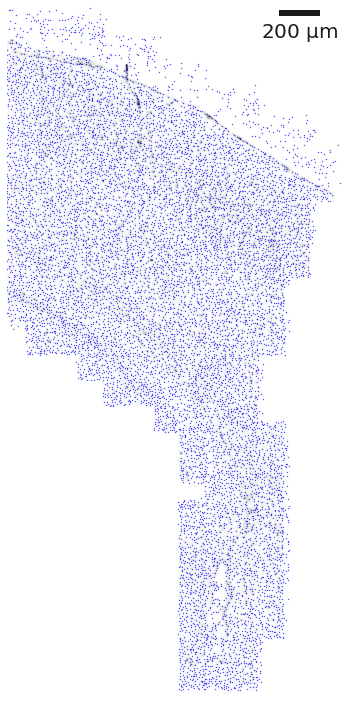

In [14]:
plt.figure(figsize=[5, 10.3])
ds.plot_l1norm(cmap="Greys", rotate=1)
plt.scatter(ds.local_maxs[0], ds.local_maxs[1], c="blue", s=0.1)

from matplotlib_scalebar.scalebar import ScaleBar
scalebar = ScaleBar(1, 'um', pad=0.2, font_properties={"size": 20})
plt.gca().add_artist(scalebar)
plt.axis('off')

plt.tight_layout()
plt.xlim([ds.vf.shape[0], 0])
plt.ylim([ds.vf.shape[1], 0])
plt.show()

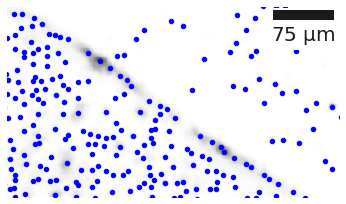

In [15]:
plt.figure(figsize=[5, 3])
ds.plot_l1norm(cmap="Greys", rotate=1)
plt.scatter(ds.local_maxs[0], ds.local_maxs[1], c="blue", s=20)

scalebar = ScaleBar(1, 'um', pad=0.2, font_properties={"size": 20}, height_fraction=0.05)
plt.gca().add_artist(scalebar)
plt.axis('off')

plt.tight_layout()
plt.xlim([760, 355])
plt.ylim([707, 475])
plt.show()

Remove spurious local maxima based on KNN density

In [16]:
from sklearn.neighbors import KDTree
X = np.array([ds.local_maxs[0], ds.local_maxs[1]]).T
kdt = KDTree(X, leaf_size=30, metric='euclidean')
rho = 100 / (np.pi * kdt.query(X, k=100)[0][:, 99] ** 2)

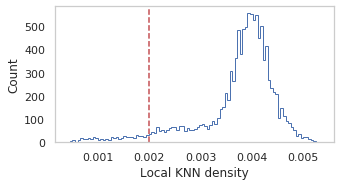

In [17]:
threshold = 0.002

plt.figure(figsize=[5, 2.5])
plt.hist(rho, bins=100, histtype='step')
plt.axvline(x=threshold, color='r', linestyle='--')

ax = plt.gca()
ax.set_xlabel("Local KNN density")
ax.set_ylabel("Count")
pass

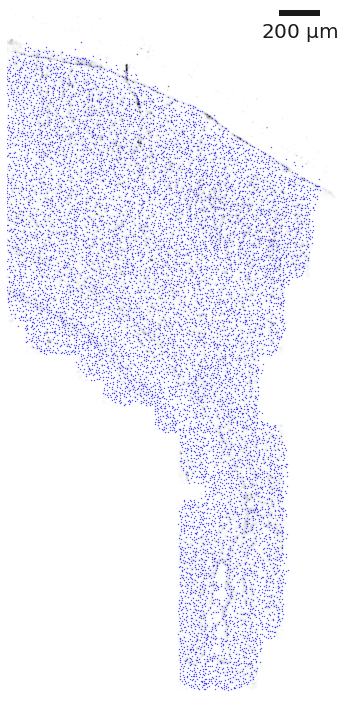

In [18]:
mask = rho > threshold

plt.figure(figsize=[5, 10.3])
ds.plot_l1norm(cmap="Greys", rotate=1)
plt.scatter(ds.local_maxs[0][mask], ds.local_maxs[1][mask], c="blue", s=0.1)

from matplotlib_scalebar.scalebar import ScaleBar
scalebar = ScaleBar(1, 'um', pad=0.2, font_properties={"size": 20})
plt.gca().add_artist(scalebar)
plt.axis('off')

plt.tight_layout()
plt.xlim([ds.vf.shape[0], 0])
plt.ylim([ds.vf.shape[1], 0])
plt.show()

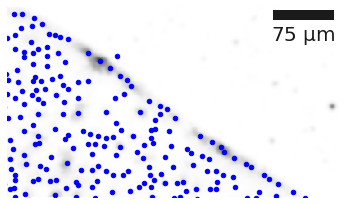

In [19]:
plt.figure(figsize=[5, 3])
ds.plot_l1norm(cmap="Greys", rotate=1)
plt.scatter(ds.local_maxs[0][mask], ds.local_maxs[1][mask], c="blue", s=20)

scalebar = ScaleBar(1, 'um', pad=0.2, font_properties={"size": 20}, height_fraction=0.05)
plt.gca().add_artist(scalebar)
plt.axis('off')

plt.tight_layout()
plt.xlim([760, 355])
plt.ylim([707, 475])
plt.show()

Apply mask

In [20]:
ds.local_maxs = tuple(ds.local_maxs[i][mask] for i in range(3))

Writing temporary files...
Running scTransform via Rscript...
Reading output files...


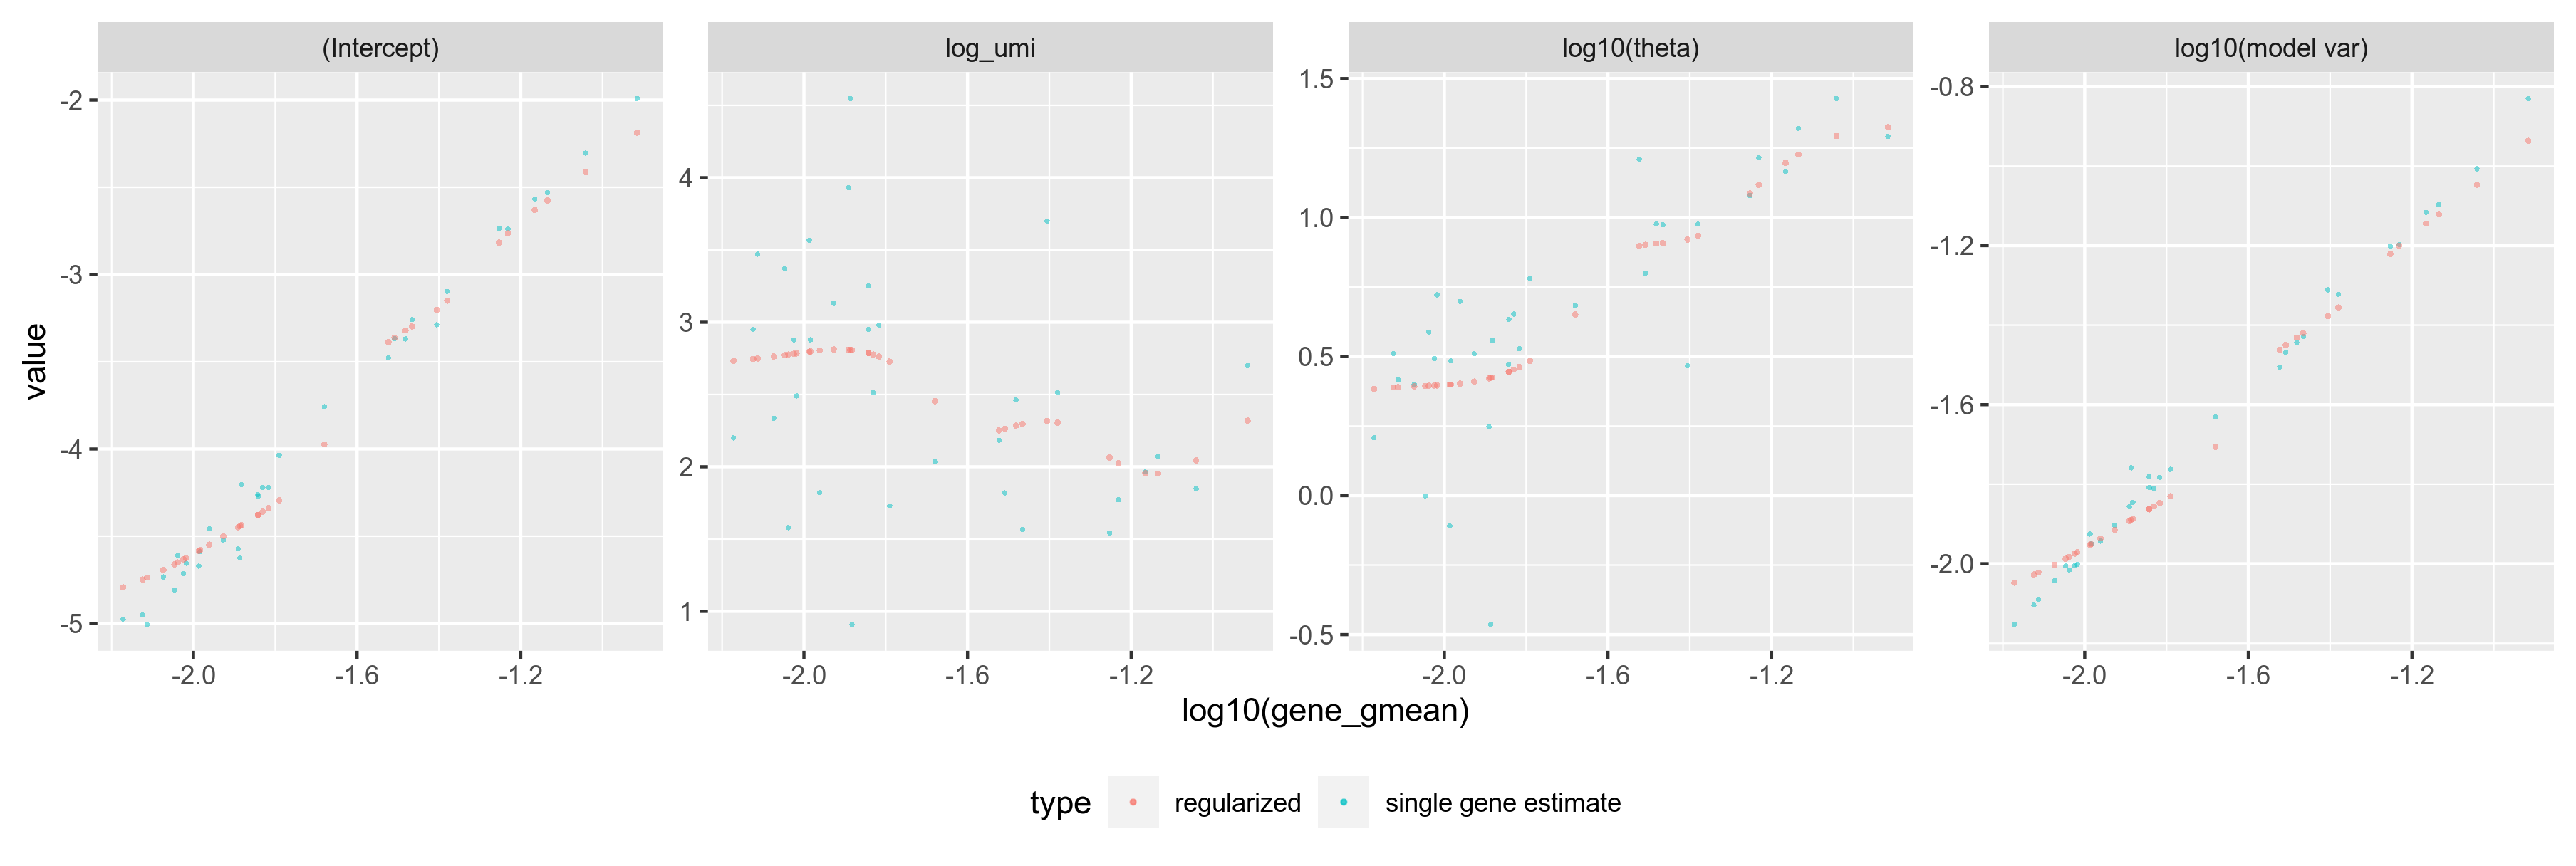

Clipping residuals...


In [21]:
analysis.normalize_vectors_sctransform(vst_kwargs={'plot_model_pars': True})

Normalize local maxima vectors and vector field

In [22]:
# this requires local R installation with packages 'sctransform' and 'feather'
analysis.normalize_vectors_sctransform()

## SSAM guided mode: using MERFISH segmentation-based centroids and scRNA-seq data (Marques *et al*. and *et al*.)

### 1) SSAM guided by segmentation-based cluster centroids

Load osmFISH segementation-based expression data

In [193]:
# Load osmFISH data
import loompy
osmfish_loom = loompy.connect("zenodo/osmFISH/raw_data/osmFISH_SScortex_mouse_all_cells.loom")

In [194]:
from sklearn.preprocessing import normalize, scale
from scipy.stats import median_test

osmfish_genes = list(osmfish_loom.row_attrs['Gene'])
osmfish_gene_indices = [osmfish_genes.index(gene) for gene in ds.genes]
osmfish_clusters = osmfish_loom.col_attrs['ClusterName']
osmfish_data = osmfish_loom[:,:].T[:, osmfish_gene_indices][osmfish_clusters != "Excluded", :]
osmfish_clusters = osmfish_clusters[osmfish_clusters != "Excluded"]
osmfish_uniq_labels = sorted(set(osmfish_clusters) - set(['Excluded']))

In [195]:
osmfish_data_normalized = np.array(ssam.run_sctransform(osmfish_data)[0])

In [196]:
osmfish_centroids = np.zeros([len(osmfish_uniq_labels), len(osmfish_genes)])
for cl_idx, osmfish_cluster in enumerate(osmfish_uniq_labels):
    osmfish_centroids[cl_idx, :] = np.mean(osmfish_data_normalized[osmfish_clusters == osmfish_cluster, :], axis=0)

In [200]:
osmfish_ref_colors = {
    "Inhibitory CP": "#9b067d",
    "Inhibitory Crhbp": "#9805cc",
    "Inhibitory Cnr1": "#ca4479",
    "Inhibitory IC": "#ff49b0",
    "Inhibitory Kcnip2": "#af7efe",
    "Inhibitory Pthlh": "#4e14a6",
    "Inhibitory Vip": "#7759a4",
    "Pyramidal Cpne5": "#3e4198",
    "Pyramidal L2-3": "#0ab4e4",
    "Pyramidal L2-3 L5": "#1e6a87",
    "Pyramidal Kcnip2": "#6787d6",
    "Pyramidal L3-4": "#004dba",
    "pyramidal L4": "#78edff",
    "Pyramidal L5": "#0a9fb4",
    "Pyramidal L6": "#027fd0",
    "Hippocampus": "#004b71",
    "Astrocyte Gfap": "#de4726",
    "Astrocyte Mfge8": "#f69149",
    "Oligodendrocyte Precursor cells": "#b3ee3d",
    "Oligodendrocyte COP": "#5dd73d",
    "Oligodendrocyte NF": "#64a44e",
    "Oligodendrocyte MF": "#2f7449",
    "Oligodendrocyte Mature": "#285528",
    "Perivascular Macrophages": "#762a14",
    "Microglia": "#a7623d",
    "C. Plexus": "#21b183",
    "Ependymal": "#fadf0b",
    "Pericytes": "#f8c495",
    "Endothelial": "#f81919",
    "Endothelial 1": "#f05556",
    "Vascular Smooth Muscle": "#aec470",
}
osmfish_colors = [osmfish_ref_colors[cl] for cl in osmfish_uniq_labels]

In [285]:
analysis.map_celltypes(osmfish_centroids)
#analysis.filter_celltypemaps(min_norm=0.5, min_r=0.6)
analysis.filter_celltypemaps(min_norm=filter_method, filter_params=filter_params, min_r=0.6)

In [191]:
import pandas as pd
from scipy.spatial.distance import cdist

def calc_matching_score(centroids, uniq_labels):
    m_corrs = cdist(centroids, osmfish_centroids, ssam.utils.corr)
    max_mask = m_corrs > 0.8
    max_mask &= m_corrs == m_corrs.max(axis=0)
    max_mask &= (m_corrs.T == m_corrs.max(axis=1)).T
    x, y = np.where(max_mask)
    high_corr_labels_bot = np.array(uniq_labels)[x]
    high_corr_labels_left = np.array(osmfish_uniq_labels)[y]

    hm_total = np.zeros([len(x), len(centroids)], dtype=int)
    hm = np.zeros([len(x), len(centroids)])

    for i, idx in enumerate(y):
        cell_indices = np.unique(seg_map[seg_ctmap == idx])
        hm_total[i, :] = len(cell_indices)
        for j in cell_indices:
            ssam_seg = ds.celltype_maps[..., 0][seg_map == j]
            ssam_cts, ssam_ctcnts = np.unique(ssam_seg, return_counts=True)
            ssam_ctfreqs = ssam_ctcnts / len(ssam_seg)
            hm[i, ssam_cts] += (ssam_ctfreqs > 0.1).astype(int)
    ms = (hm / hm_total)[:, x]
    df = pd.DataFrame({
        "Reference cell types": np.array(osmfish_uniq_labels)[y],
        "Given cell types": np.array(uniq_labels)[x],
        "Pearson's r": np.round(m_corrs[x, y], 2),
        "Matched segments": np.diag(hm[:, x].astype(int)),
        "Total segments": np.diag(hm_total[:, x]),
        "Matching score": np.round(np.diag(ms), 2),
    })
    return high_corr_labels_bot, high_corr_labels_left, df, ms

In [209]:
lbl_bot, lbl_left, df, ms_heatmap = calc_matching_score(osmfish_centroids, osmfish_uniq_labels)
df

Reference cell types                 Given cell types  \
0                    Astrocyte Gfap                   Astrocyte Gfap   
1                   Astrocyte Mfge8                  Astrocyte Mfge8   
2                         C. Plexus                        C. Plexus   
3                       Endothelial                      Endothelial   
4                     Endothelial 1                    Endothelial 1   
5                         Ependymal                        Ependymal   
6                       Hippocampus                      Hippocampus   
7                     Inhibitory CP                    Inhibitory CP   
8                   Inhibitory Cnr1                  Inhibitory Cnr1   
9                  Inhibitory Crhbp                 Inhibitory Crhbp   
10                    Inhibitory IC                    Inhibitory IC   
11                Inhibitory Kcnip2                Inhibitory Kcnip2   
12                 Inhibitory Pthlh                 Inhibitory Pthlh   
13                   Inhibitory Vip                   Inhibitory Vip   
14                        Microglia                        Microglia   
15              Oligodendrocyte COP              Oligodendrocyte COP   
16               Oligodendrocyte MF               Oligodendrocyte MF   
17           Oligodendrocyte Mature           Oligodendrocyte Mature   
18               Oligodendrocyte NF               Oligodendrocyte NF   
19  Oligodendrocyte Precursor cells  Oligodendrocyte Precursor cells   
20                        Pericytes                        Pericytes   
21         Perivascular Macrophages         Perivascular Macrophages   
22                  Pyramidal Cpne5                  Pyramidal Cpne5   
23                 Pyramidal Kcnip2                 Pyramidal Kcnip2   
24                   Pyramidal L2-3                   Pyramidal L2-3   
25                Pyramidal L2-3 L5                Pyramidal L2-3 L5   
26                   Pyramidal L3-4                   Pyramidal L3-4   
27                     Pyramidal L5                     Pyramidal L5   
28                     Pyramidal L6                     Pyramidal L6   
29           Vascular Smooth Muscle           Vascular Smooth Muscle   
30                     pyramidal L4                     pyramidal L4   

    Pearson's r  Matched segments  Total segments  Matching score  
0           1.0                77              81            0.95  
1           1.0                 1             119            0.01  
2           1.0                 2              50            0.04  
3           1.0                 2             235            0.01  
4           1.0                 3              94            0.03  
5           1.0                 6             107            0.06  
6           1.0                 7             133            0.05  
7           1.0                 2             161            0.01  
8           1.0                 2              40            0.05  
9           1.0                 3             120            0.02  
10          1.0                 0              78            0.00  
11          1.0                 0              83            0.00  
12          1.0                 9              95            0.09  
13          1.0                 4             126            0.03  
14          1.0                 4              52            0.08  
15          1.0                 1             142            0.01  
16          1.0                 1              97            0.01  
17          1.0                 2             381            0.01  
18          1.0                 2              76            0.03  
19          1.0                 2             111            0.02  
20          1.0                 4              94            0.04  
21          1.0                 2              66            0.03  
22          1.0                 1              76            0.01  
23          1.0                 0              25            0.00  
24        

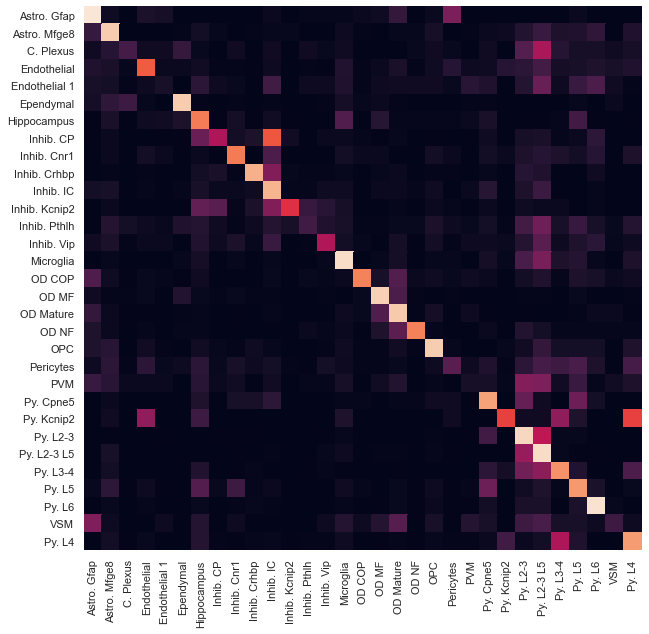

In [290]:
plt.figure(figsize=[10, 10])
sns.heatmap(ms_heatmap,
            yticklabels=shorten_labels(lbl_bot),
            xticklabels=shorten_labels(lbl_left), cbar=False, vmin=0, vmax=1)
pass

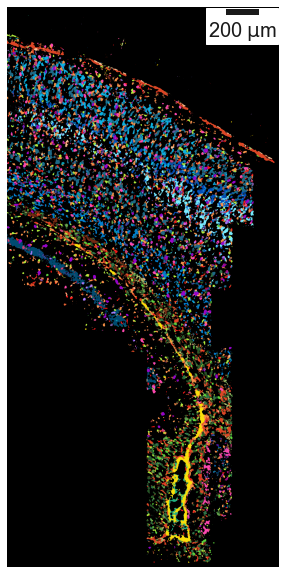

In [92]:
plt.figure(figsize=[5, 10.3])
ds.plot_celltypes_map(colors=osmfish_colors, rotate=1, set_alpha=False)
scalebar = ScaleBar(1, 'um', pad=0.1, font_properties={"size": 20})
plt.gca().add_artist(scalebar)
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
sns.despine(top=True, bottom=True, left=True, right=True)
pass

In [97]:
nonzero_vf = ds.normalized_vf[ds.vf_norm > norm_thres]

0 0.9210079719521115
1 0.9225968786170948
2 0.9204297769487835
3 0.9195013367071797
4 0.9231389113449471
5 0.9188554977789304
6 0.9189256541437006
7 0.9214234441832055
8 0.9188311204742261
9 0.9197225908164347
10 0.9204906414213723
11 0.9210749638244587
12 0.9216477278246472
13 0.9211737947159184
14 0.9177021623139234
15 0.9177886744262158
16 0.9204258207755925
17 0.9207127383205734
18 0.9218021084408922
19 0.9224264034237925
20 0.9198546903136962
21 0.919906234836688
22 0.9188865957385737
23 0.9224113445005327
24 0.9200528612080486
25 0.9198112065934451
26 0.9195183934873394
27 0.9235784112230153
28 0.9228818239743687
29 0.9227724026197056
30 0.9217066171219671
31 0.9216739615271252
32 0.9197885194548756
33 0.9213569414800674
34 0.9189699937806155
35 0.9221651482331664
36 0.918875609690691
37 0.9230360028856638
38 0.9217181308813417
39 0.9178770314010738
40 0.9245359602781424
41 0.923137386271162
42 0.9179986153399285
43 0.9191328875343194
44 0.9207687310621322
45 0.9206065532691224
4

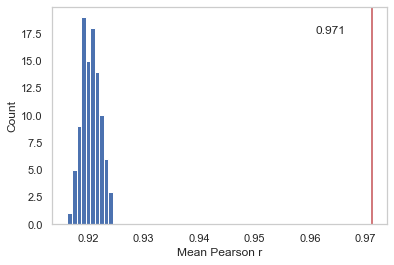

In [100]:
from numpy.random import default_rng
rng = default_rng()
p = np.zeros(len(osmfish_centroids))
for i in range(len(osmfish_centroids)):
    p = ssam.corr(osmfish_centroids[i], np.mean(ds.normalized_vectors[ds.celltype_maps[ds.local_maxs] == i], axis=0))
dist_localmax_mean = np.mean(p)
dist_random_means = []
for cnt in range(100):
    rnd_indices = rng.choice(nonzero_vf.shape[0], size=ds.normalized_vectors.shape[0], replace=False)
    rnd_indices = np.sort(rnd_indices)
    rnd_vecs = nonzero_vf[rnd_indices]
    rnd_cts = ds.celltype_maps[ds.vf_norm > 0.04][rnd_indices]
    p = np.zeros(len(osmfish_centroids))
    for i in range(len(osmfish_centroids)):
        p[i] = ssam.corr(osmfish_centroids[i], np.mean(rnd_vecs[rnd_cts == i], axis=0))
    dist_random_mean = np.mean(p)
    dist_random_means.append(dist_random_mean)
    print(cnt, dist_random_mean)
plt.hist(dist_random_means, bins=10)
plt.axvline(x=dist_localmax_mean, c='r')
plt.text(dist_localmax_mean, 900, '%.3f'%dist_localmax_mean, transform=ax.get_yaxis_transform())
plt.xlabel('Mean Pearson r')
plt.ylabel('Count')
plt.show()

### 2) SSAM guided by scRNA-seq cluster centroids

In [108]:
# Load scRNAseq data
scrna_loom = loompy.connect("zenodo/osmFISH/raw_data/single-cell_cortex_oligo.loom")
scrna_genes_idx = [list(scrna_loom.row_attrs['genes']).index(g) for g in ds.genes]
scrna_labels = np.array(scrna_loom.col_attrs['labels'])
scrna_matrix = scrna_loom[:, :].T
scrna_matrix = scrna_matrix[:, scrna_genes_idx] + 0.01 # Add a small nudge for geomean calculation during normalization

In [109]:
# Normalize it with sctransform
scrna_matrix_normalized = np.array(ssam.run_sctransform(scrna_matrix)[0])

In [110]:
scrna_uniq_labels = np.unique(scrna_labels) # np.unique is sorted
scrna_centroids = np.zeros([len(scrna_uniq_labels), len(ds.genes)])
for cidx, cl in enumerate(scrna_uniq_labels):
    scrna_centroids[cidx, :] = np.mean(scrna_matrix_normalized[scrna_labels == cl, :], axis=0)

In [111]:
analysis.map_celltypes(scrna_centroids)
#analysis.filter_celltypemaps(min_norm=0.5, min_r=0.4)
analysis.filter_celltypemaps(min_norm=filter_method, filter_params=filter_params, min_r=0.4)

In [112]:
# Define color of scRNAseq data based on colors of segmentation-based data
from matplotlib import colors

osm_scrna_corrs = np.zeros((len(scrna_centroids), len(osmfish_centroids)))
for i, scrna_centroid in enumerate(scrna_centroids):
    for j, osmfish_centroid in enumerate(osmfish_centroids):
        osm_scrna_corrs[i, j] = ssam.utils.corr(scrna_centroid, osmfish_centroid)

osm_scrna_max_corr = np.max(osm_scrna_corrs, axis=1)
osm_scrna_max_corr_idx = np.argmax(osm_scrna_corrs, axis=1)
osm_scrna_rowheaders_corr = np.array(osmfish_uniq_labels)[osm_scrna_max_corr_idx]

# Beware that this can make some clusters have the same color!
scrna_colors_dic = {}
for scrna_cl, osm_cl in zip(scrna_uniq_labels, osm_scrna_rowheaders_corr):
    col = osmfish_ref_colors.get(osm_cl, 'black')
    if col != 'black':
        while col in scrna_colors_dic:
            r, g, b = colors.to_rgb(col)
            r -= 0.05; r = 0.0 if r < 0.0 else r
            g -= 0.05; g = 0.0 if g < 0.0 else g
            b -= 0.05; b = 0.0 if b < 0.0 else b
            col = colors.to_hex([r,g,b])
    scrna_colors_dic[scrna_cl] = col
scrna_colors = [scrna_colors_dic[cl] for cl in scrna_uniq_labels]

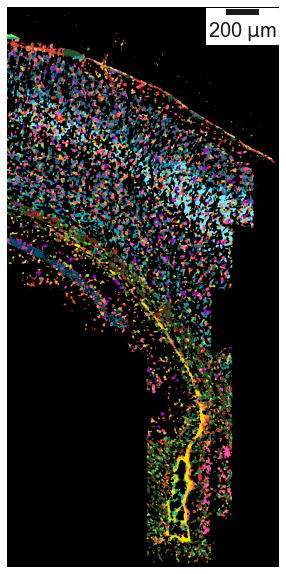

In [113]:
plt.figure(figsize=[5, 10.3])
ds.plot_celltypes_map(colors=scrna_colors, rotate=1, set_alpha=False)
scalebar = ScaleBar(1, 'um', pad=0.1, font_properties={"size": 20})
plt.gca().add_artist(scalebar)
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
sns.despine(top=True, bottom=True, left=True, right=True)

In [282]:
lbl_bot, lbl_left, df, ms_heatmap = calc_matching_score(scrna_centroids, scrna_uniq_labels)

In [283]:
df

Reference cell types Given cell types  Pearson's r  \
0                   Astrocyte Mfge8           Astro2         0.83   
1               Oligodendrocyte COP              COP         0.80   
2                    Inhibitory Vip            Int10         0.83   
3                     Inhibitory IC            Int13         0.91   
4                  Inhibitory Crhbp             Int2         0.88   
5                   Inhibitory Cnr1             Int5         0.94   
6                         Microglia             Mgl1         0.81   
7                Oligodendrocyte NF            NFOL1         0.86   
8   Oligodendrocyte Precursor cells              OPC         0.91   
9                         Pericytes              PPR         0.89   
10         Perivascular Macrophages             Pvm1         0.81   
11                Pyramidal L2-3 L5         S1PyrL23         0.92   
12                     pyramidal L4         S1PyrL5a         0.93   
13                      Endothelial            Vend2         0.83   
14           Vascular Smooth Muscle             Vsmc         0.83   

    Matched segments  Total segments  Matching score  
0                103             119            0.87  
1                109             142            0.77  
2                 14             126            0.11  
3                 64              78            0.82  
4                 84             120            0.70  
5                 25              40            0.62  
6                 48              52            0.92  
7                 53              76            0.70  
8                102             111            0.92  
9                 12              94            0.13  
10                 5              66            0.08  
11               286             288            0.99  
12               294             483            0.61  
13               153             235            0.65  
14                 4              31            0.13

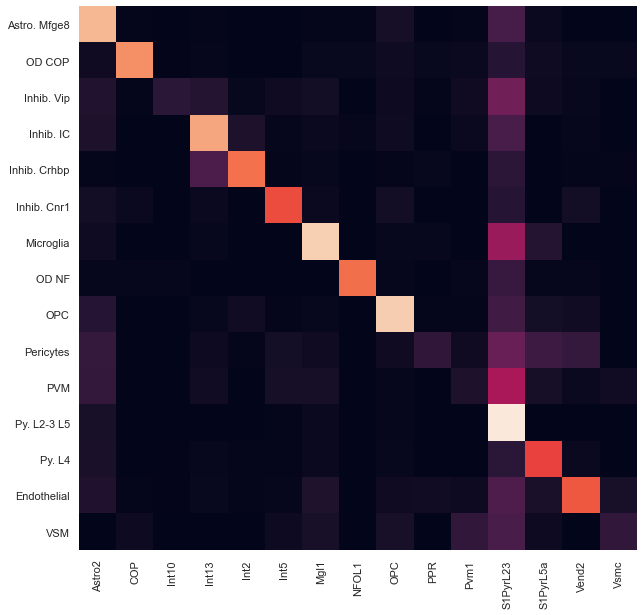

In [284]:
plt.figure(figsize=[10, 10])
sns.heatmap(ms_heatmap,
            yticklabels=shorten_labels(lbl_left),
            xticklabels=lbl_bot, cbar=False, vmin=0, vmax=1)
pass

## SSAM *de novo* mode

In [23]:
analysis.cluster_vectors(pca_dims=33, resolution=0.15, max_correlation=1.0, metric="correlation", centroid_correction_threshold=0.6)

Found 66 clusters


In [23]:
analysis.map_celltypes()
analysis.filter_celltypemaps(min_norm=filter_method, filter_params=filter_params, min_r=0.6, fill_blobs=True, min_blob_area=50)

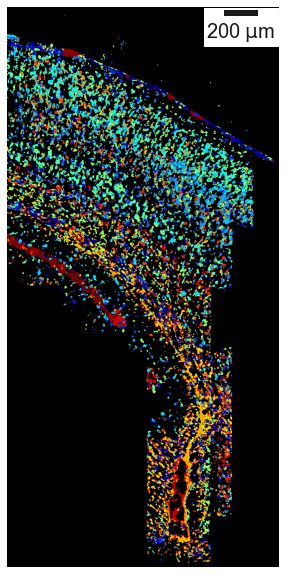

In [24]:
plt.figure(figsize=[5, 10.3])
ds.plot_celltypes_map(rotate=1, set_alpha=False)

scalebar = ScaleBar(1, 'um', pad=0.2, font_properties={"size": 20})
plt.gca().add_artist(scalebar)

plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
sns.despine(top=True, bottom=True, left=True, right=True)

In [39]:
load_tsne('excluded')

(-111.40979437184954, 88.78233770681048, -98.303474220407, 92.76610544599293)

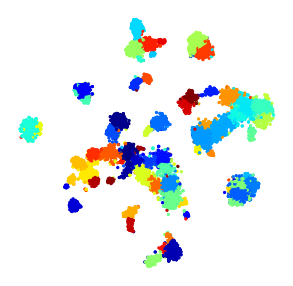

In [40]:
import matplotlib.patheffects as PathEffects
plt.figure(figsize=[5, 5])
ds.plot_tsne(pca_dims=33, metric="correlation", s=5, run_tsne=False)
plt.axis('off')

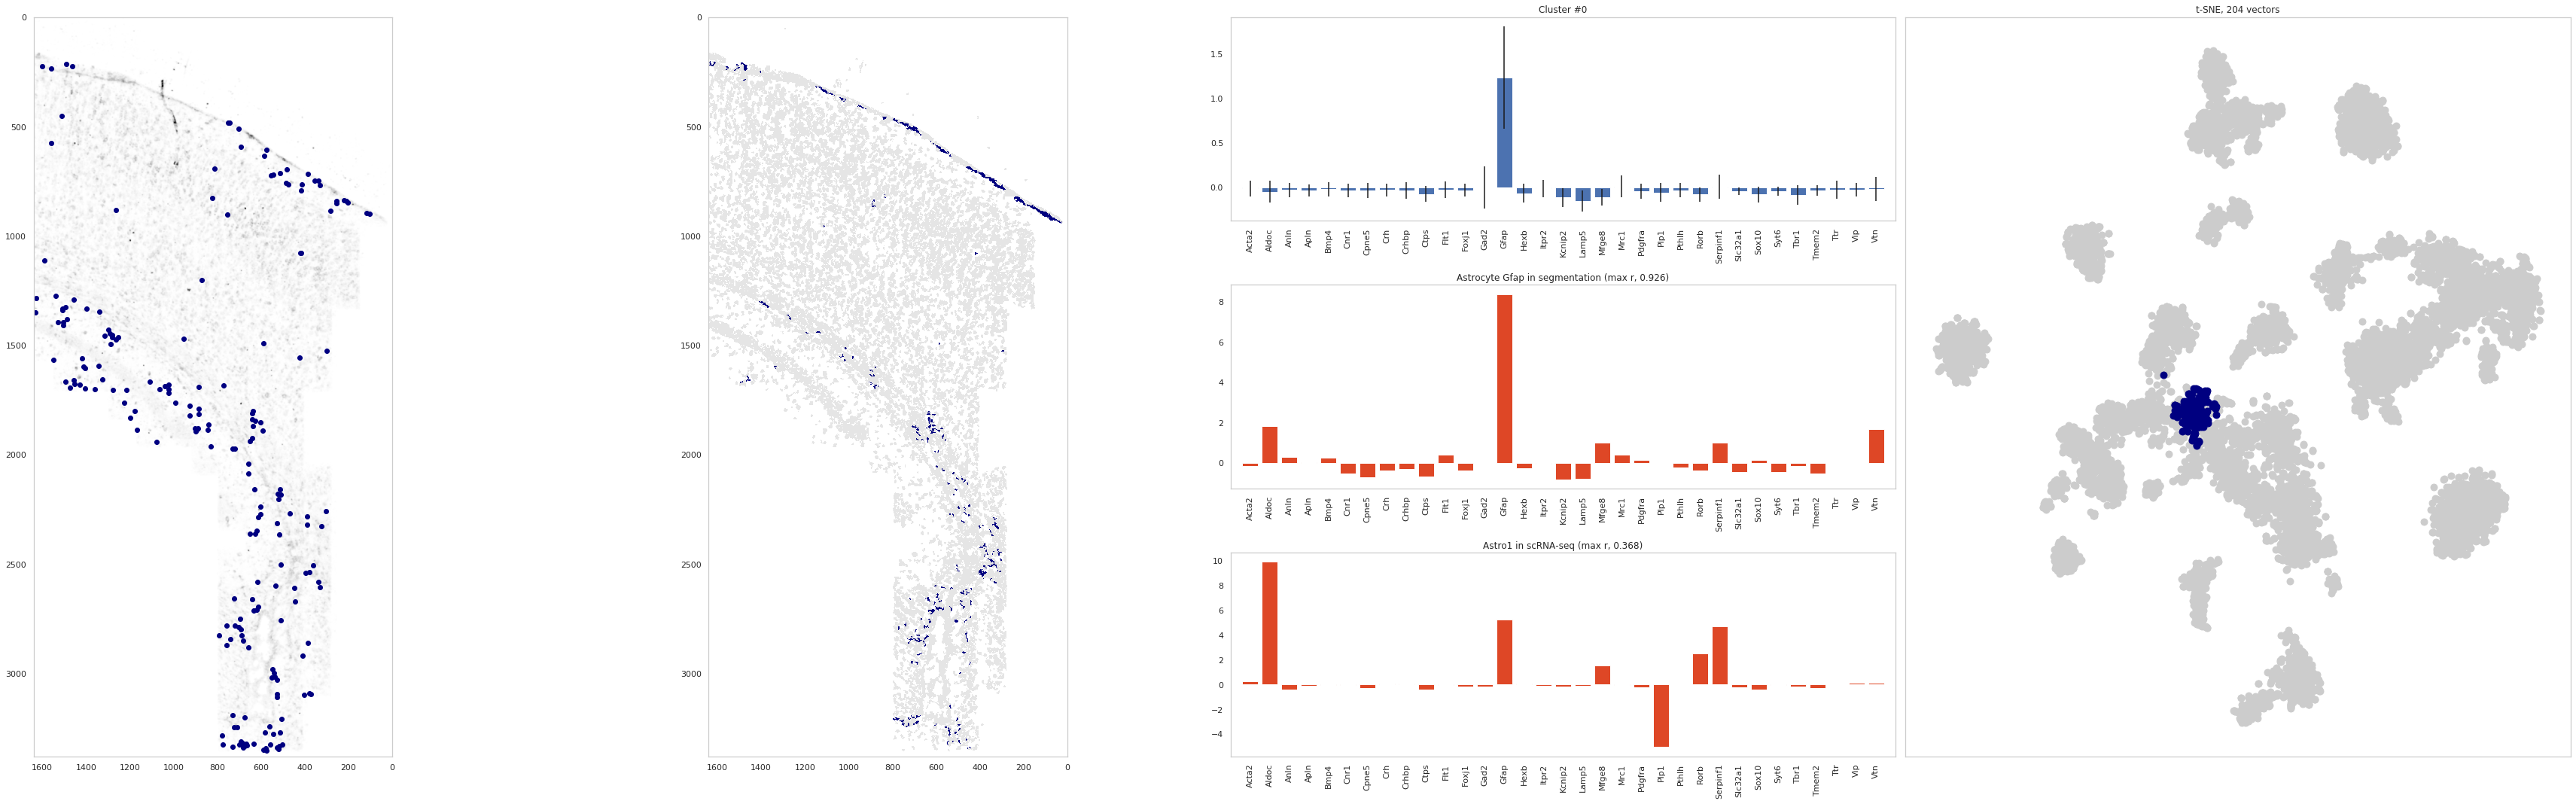

In [41]:
from scipy.stats import pearsonr, spearmanr

for idx in range(len(ds.centroids)):
    plt.figure(figsize=[50, 15])
    ds.plot_diagnostic_plot(idx, known_signatures=[
        ("segmentation", osmfish_uniq_labels, osmfish_centroids, osmfish_colors),
        ("scRNA-seq", scrna_uniq_labels, scrna_centroids, scrna_colors),
    ], correlation_methods=[
        ("r", pearsonr),
    ])
    plt.tight_layout()
    plt.savefig('diagplots_osmFISH/diagplot_centroid_%d.png'%idx)
    #plt.close()
    break

In [24]:
denovo_labels = [
    "Astrocyte Gfap",
    "Perivascular Macrophages",
    "N/A",
    "Endothelial",
    "Astrocyte Gfap (Aldoc)",
    "Oligodendrocyte COP",
    "Oligodendrocyte NF",
    "Microglia",
    "Endothelial 1",
    "Astrocyte Aldoc",
    
    "Pyramidal Cpne5",
    "Inhibitory Vip",
    "Astrocyte Gfap (Aldoc)",
    "Vascular Smooth Muscle",
    "N/A",
    "Pyramidal L5 (Tbr1)",
    "N/A",
    "Astrocyte Mfge8",
    "pyramidal L4",
    "Pyramidal L3-4",
    
    "N/A",
    "Inhibitory Pthlh",
    "Inhibitory Crhbp",
    "Pyramidal L2-3 L5",
    "Pyramidal L2-3 L5 (Tbr1)",
    "Oligodendrocyte Precursor cells",
    "N/A (Aldoc and Inhib neuron mixture?)",
    "Pyramidal L2-3 L5",
    "Microglia",
    "Astrocyte Mfge8",
    
    "Pyramidal L2-3 L5",
    "Astrocyte Mfge8",
    "N/A",
    "N/A",
    "Pericytes",
    "Inhibitory Rest",
    "Pyramidal L6",
    "Pyramidal L2-3 L5",
    "Microglia",
    "Astrocyte Gfap (Tbr1)",
    
    "Astrocyte Gfap (Aldoc, Mfge8)",
    "Oligodendrocyte Precursor cells",
    "pyramidal L4",
    "Oligodendrocyte Mature",
    "N/A",
    "Oligodendrocyte NF",
    "Oligodendrocyte MF",
    "Ependymal",
    "Pyramidal L3-4",
    "Pyramidal L2-3",
    
    "N/A",
    "Endothelial (Endothelial and Mfge8 mixture?)",
    "Astrocyte Mfge8",
    "Astrocyte Gfap",
    "Inhibitory Cnr1",
    "Pyramidal L6",
    "Oligodendrocyte Mature",
    "Inhibitory Kcnip2",
    "Endothelial",
    "Inhibitory Kcnip2",
    
    "Hippocampus",
    "C. Plexus",
    "Oligodendrocyte Mature",
    "Astrocyte Gfap (Astrocyte and Kcnip2 mixture?)",
    "N/A (Artifact)",
    "Hippocampus",
]

In [27]:
denovo_labels_final = []
exclude_indices = []
merge_indices = []
import re

p = re.compile(r' \(.*\)')

denovo_labels_short = [p.sub("", cl) for cl in denovo_labels]
for idx, cl in enumerate(denovo_labels_short):
    if cl == 'N/A':
        exclude_indices.append(idx)
        continue
    if cl in denovo_labels_final:
        continue
    denovo_labels_final.append(cl)
for cl in np.unique(denovo_labels_short):
    if cl == 'N/A':
        continue
    mask = [cl == e for e in denovo_labels_short]
    if np.sum(mask) > 1:
        merge_indices.append(np.where(mask)[0])

(-111.40979437184954, 88.78233770681048, -98.303474220407, 92.76610544599293)

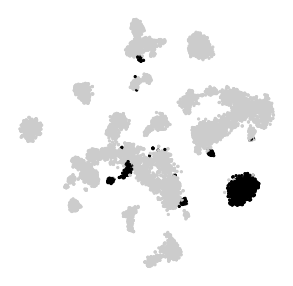

In [44]:
cmap = plt.get_cmap('jet')
jet_colors = cmap(np.array(list(range(len(ds.centroids)))) / (len(ds.centroids) - 1))
tsne_colors = np.zeros_like(jet_colors)
tsne_colors[..., :] = [0.8, 0.8, 0.8, 1]
tsne_colors[exclude_indices] = [0, 0, 0, 1] #jet_colors[exclude_indices]
import matplotlib.patheffects as PathEffects
plt.figure(figsize=[5, 5])
ds.plot_tsne(pca_dims=33, metric="correlation", s=5, run_tsne=False, colors=tsne_colors)
plt.gca().axis('off')

(-112.29564684617479, 89.66819018113573, -99.17135271252965, 93.63398393811565)

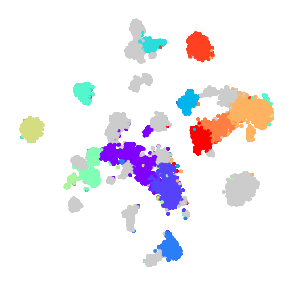

In [45]:
cmap = plt.get_cmap('rainbow')
jet_colors = cmap(np.array(list(range(len(merge_indices)))) / (len(merge_indices) - 1))
plt.figure(figsize=[5, 5])
tsne_colors = np.zeros([len(ds.centroids), 4])
tsne_colors[..., :] = [0.8, 0.8, 0.8, 1]
for idx, mi in enumerate(merge_indices):
    tsne_colors[mi] = jet_colors[idx]
    ds.plot_tsne(pca_dims=33, metric="correlation", s=5, run_tsne=False, colors=tsne_colors)
plt.gca().axis('off')

In [28]:
analysis.exclude_and_merge_clusters(exclude_indices, merge_indices, centroid_correction_threshold=0.6)

/icgc/dkfzlsdf/analysis/B260/users/parkj/miniconda3/envs/oldssam/lib/python3.8/site-packages/ssam-1.0.1-py3.8-linux-x86_64.egg/ssam/__init__.py:1203: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  merge = np.array(merge)


In [300]:
import matplotlib
denovo_celltype_colors = []
for cl in denovo_labels_final:
    if cl == "Astrocyte Aldoc":
        col = "#e87038"
    elif cl == "Inhibitory Rest":
        col = osmfish_ref_colors.get("Inhibitory IC")
    else:
        col = osmfish_ref_colors.get(cl)
    denovo_celltype_colors.append(col)

In [309]:
ds.normalized_vectors[ds.filtered_cluster_labels > -1].shape

(8252, 33)

In [301]:
heatmap_clusters_ordered = [
    'Inhibitory Kcnip2',
    'Inhibitory Crhbp',
    'Inhibitory Cnr1',
    'Inhibitory Rest',
    'Inhibitory Pthlh',
    'Inhibitory Vip',
    'Pyramidal Cpne5',
    'Pyramidal L2-3',
    'Pyramidal L2-3 L5',
    'Pyramidal L3-4',
    'pyramidal L4',
    'Pyramidal L5',
    'Pyramidal L6',
    'Hippocampus',
    'Astrocyte Aldoc',
    'Astrocyte Gfap',
    'Astrocyte Mfge8',
    'Oligodendrocyte Precursor cells',
    'Oligodendrocyte COP',
    'Oligodendrocyte NF',
    'Oligodendrocyte MF',
    'Oligodendrocyte Mature',
    'Perivascular Macrophages',
    'Microglia',
    'C. Plexus',
    'Ependymal',
    'Pericytes',
    'Endothelial',
    'Endothelial 1',
    'Vascular Smooth Muscle',
]
heatmap_genes_ordered = [
    'Gad2',
    'Slc32a1',
    'Crhbp',
    'Cnr1',
    'Vip',
    'Cpne5',
    'Pthlh',
    'Crh',
    'Tbr1',
    'Lamp5',
    'Rorb',
    'Syt6',
    'Kcnip2',
    'Aldoc',
    'Gfap',
    'Serpinf1',
    'Mfge8',
    'Sox10',
    'Plp1',
    'Pdgfra',
    'Bmp4',
    'Itpr2',
    'Tmem2',
    'Ctps',
    'Anln',
    'Mrc1',
    'Hexb',
    'Ttr',
    'Foxj1',
    'Vtn',
    'Flt1',
    'Apln',
    'Acta2'
]
heatmap_clusters_index = [denovo_labels_final.index(cl) for cl in heatmap_clusters_ordered]
heatmap_genes_index = [ds.genes.index(g) for g in heatmap_genes_ordered]

In [302]:
from matplotlib.colors import to_rgba

heatmap_vectors = np.zeros([np.sum(ds.filtered_cluster_labels != -1), len(ds.genes)], dtype=float)
col_colors = np.zeros([np.sum(ds.filtered_cluster_labels != -1), 4])
acc_idx = 0
acc_sizes = []
for cl_idx in heatmap_clusters_index:
    cl_vecs = ds.normalized_vectors[ds.filtered_cluster_labels == cl_idx]
    acc_sizes.append(cl_vecs.shape[0])
    col = denovo_celltype_colors[cl_idx]
    heatmap_vectors[acc_idx:acc_idx+cl_vecs.shape[0], :] = cl_vecs
    col_colors[acc_idx:acc_idx+cl_vecs.shape[0]] = to_rgba(col)
    acc_idx = np.sum(acc_sizes)
heatmap_vectors = heatmap_vectors[:, heatmap_genes_index]

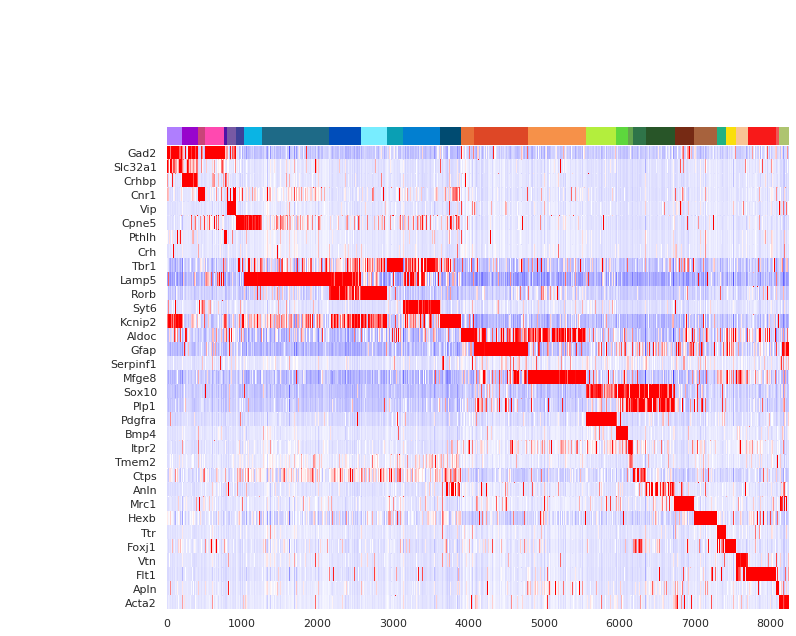

In [303]:
import seaborn as sns
gene_exp_heatmap = heatmap_vectors.T
gene_exp_heatmap = preprocessing.scale(gene_exp_heatmap)
g = sns.clustermap(gene_exp_heatmap, figsize=[12, 9], yticklabels=heatmap_genes_ordered,
                 cmap='bwr', row_cluster=False, col_cluster=False,
                 col_colors=col_colors, xticklabels = 1000, vmin=-2.5, vmax=2.5)
g.cax.set_visible(False)
g.ax_heatmap.tick_params(labelright=False, labelleft=True, right=False)

In [89]:
good_vectors = ds.vf[ds.local_maxs][ds.filtered_clusterS_labels > -1]
import doubletdetection
clf = doubletdetection.BoostClassifier(use_phenograph=False) # use_phenograph causes error; setting this False to use Louvain clustering
labels = clf.fit(good_vectors).predict()

In [120]:
sum(labels == 1) / len(labels) * 100

0.9088705768298594

In [121]:
import scrublet as scr
eps = np.finfo(float).eps
scrub = scr.Scrublet(good_vectors)
doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts=eps, min_cells=eps, min_gene_variability_pctl=eps)

Preprocessing...
Simulating doublets...


/icgc/dkfzlsdf/analysis/B260/users/parkj/miniconda3/envs/oldssam/lib/python3.8/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/icgc/dkfzlsdf/analysis/B260/users/parkj/miniconda3/envs/oldssam/lib/python3.8/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.77
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 1.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 4.9 seconds


In [37]:
heatmap_clusters_ordered_short = shorten_labels(heatmap_clusters_ordered)

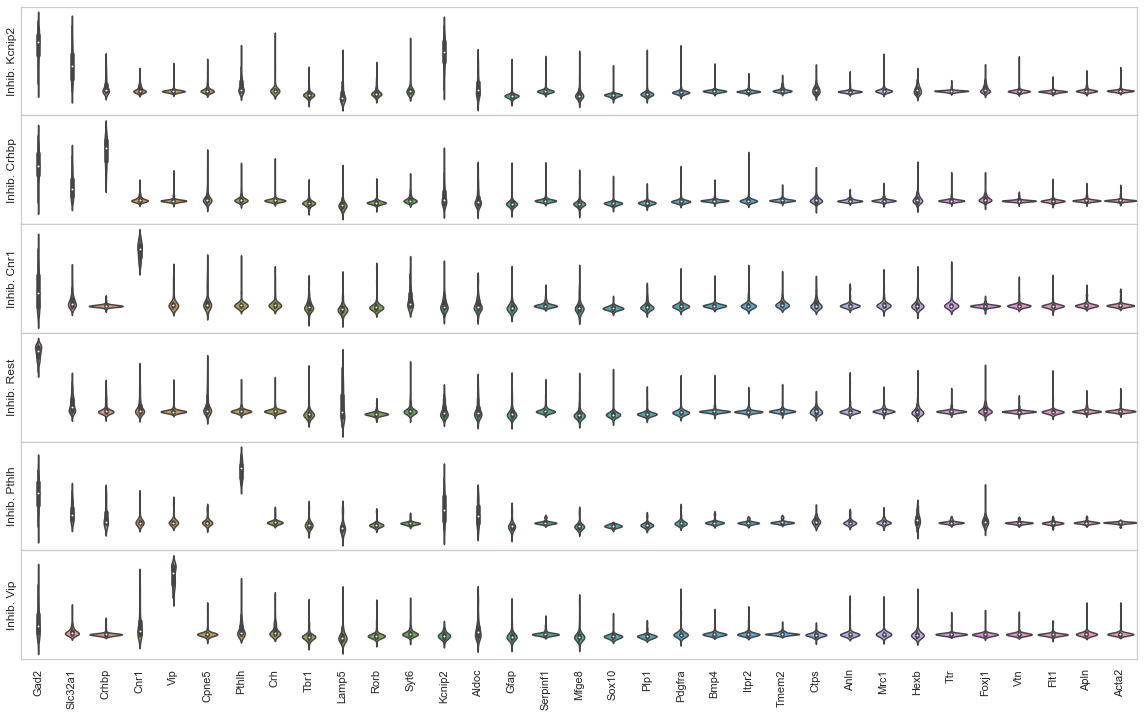

In [40]:
s = 0
e = 6

indices = heatmap_clusters_index[s:e]
acc_lens = acc_sizes[s:e]
ylabels = heatmap_clusters_ordered_short[s:e]

fig, axes = plt.subplots(len(indices), 1, figsize=[20, len(indices)*2])
plt.subplots_adjust(hspace=0)
for idx in range(len(indices)):
    acc_idx = np.sum(acc_lens[:idx]).astype(int)
    cl_vecs = gene_exp_heatmap.T[acc_idx:acc_idx+acc_lens[idx]]
    sns.violinplot(ax=axes[idx], data=cl_vecs, width=1)
    axes[idx].set_ylabel(ylabels[idx])
    axes[idx].set_yticks([])
axes[idx].set_xticklabels(heatmap_genes_ordered, rotation=90)
pass

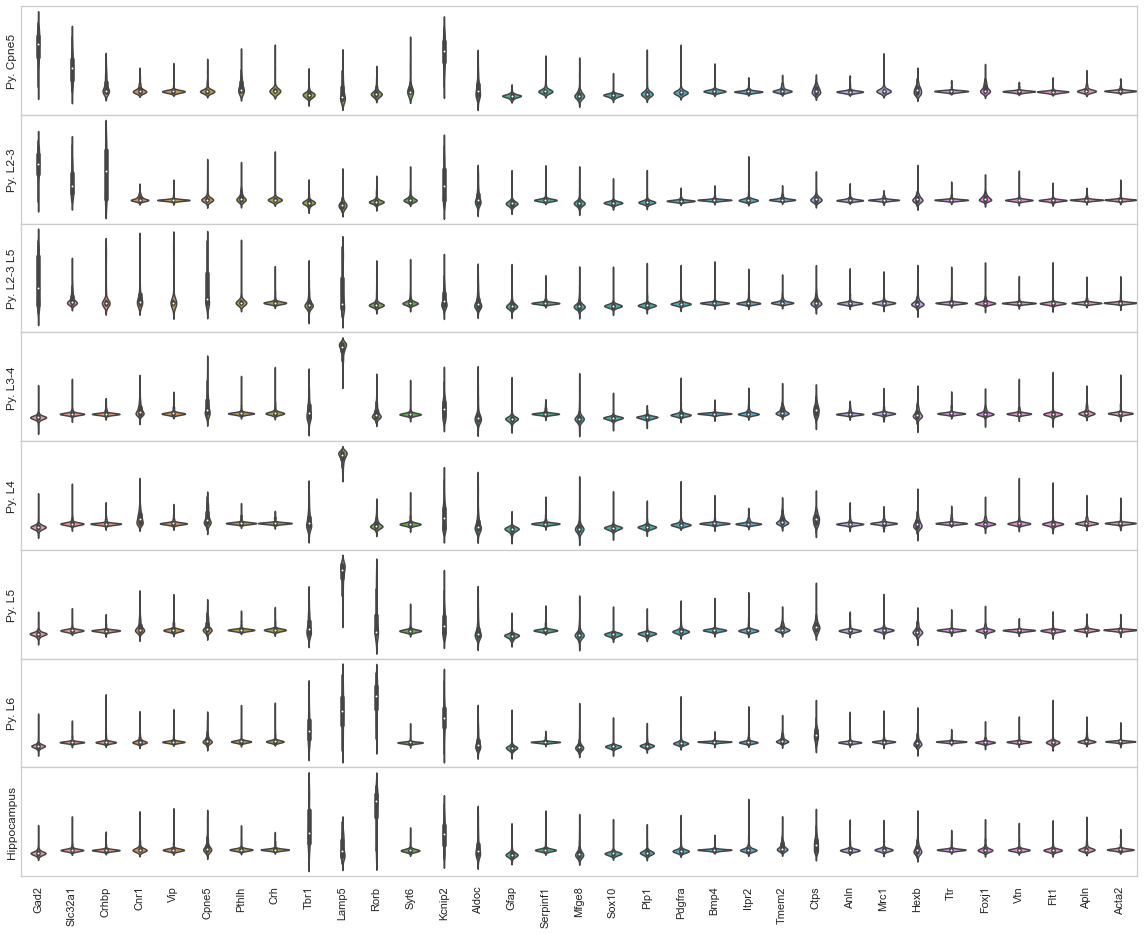

In [41]:
s = 6
e = 14

indices = heatmap_clusters_index[s:e]
acc_lens = acc_sizes[s:e]
ylabels = heatmap_clusters_ordered_short[s:e]

fig, axes = plt.subplots(len(indices), 1, figsize=[20, len(indices)*2])
plt.subplots_adjust(hspace=0)
for idx in range(len(indices)):
    acc_idx = np.sum(acc_lens[:idx]).astype(int)
    cl_vecs = gene_exp_heatmap.T[acc_idx:acc_idx+acc_lens[idx]]
    sns.violinplot(ax=axes[idx], data=cl_vecs, width=1)
    axes[idx].set_ylabel(ylabels[idx])
    axes[idx].set_yticks([])
axes[idx].set_xticklabels(heatmap_genes_ordered, rotation=90)
pass

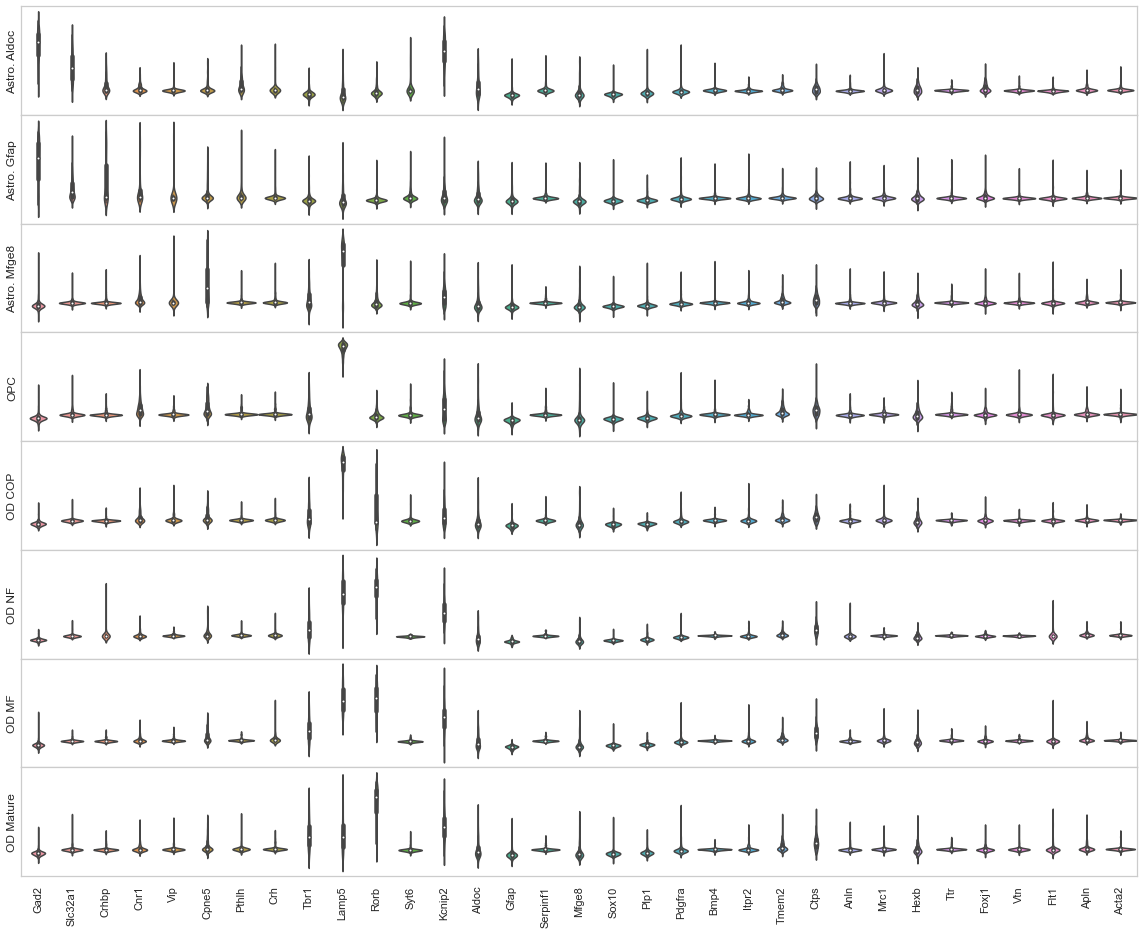

In [42]:
s = 14
e = 22

indices = heatmap_clusters_index[s:e]
acc_lens = acc_sizes[s:e]
ylabels = heatmap_clusters_ordered_short[s:e]

fig, axes = plt.subplots(len(indices), 1, figsize=[20, len(indices)*2])
plt.subplots_adjust(hspace=0)
for idx in range(len(indices)):
    acc_idx = np.sum(acc_lens[:idx]).astype(int)
    cl_vecs = gene_exp_heatmap.T[acc_idx:acc_idx+acc_lens[idx]]
    sns.violinplot(ax=axes[idx], data=cl_vecs, width=1)
    axes[idx].set_ylabel(ylabels[idx])
    axes[idx].set_yticks([])
axes[idx].set_xticklabels(heatmap_genes_ordered, rotation=90)
pass

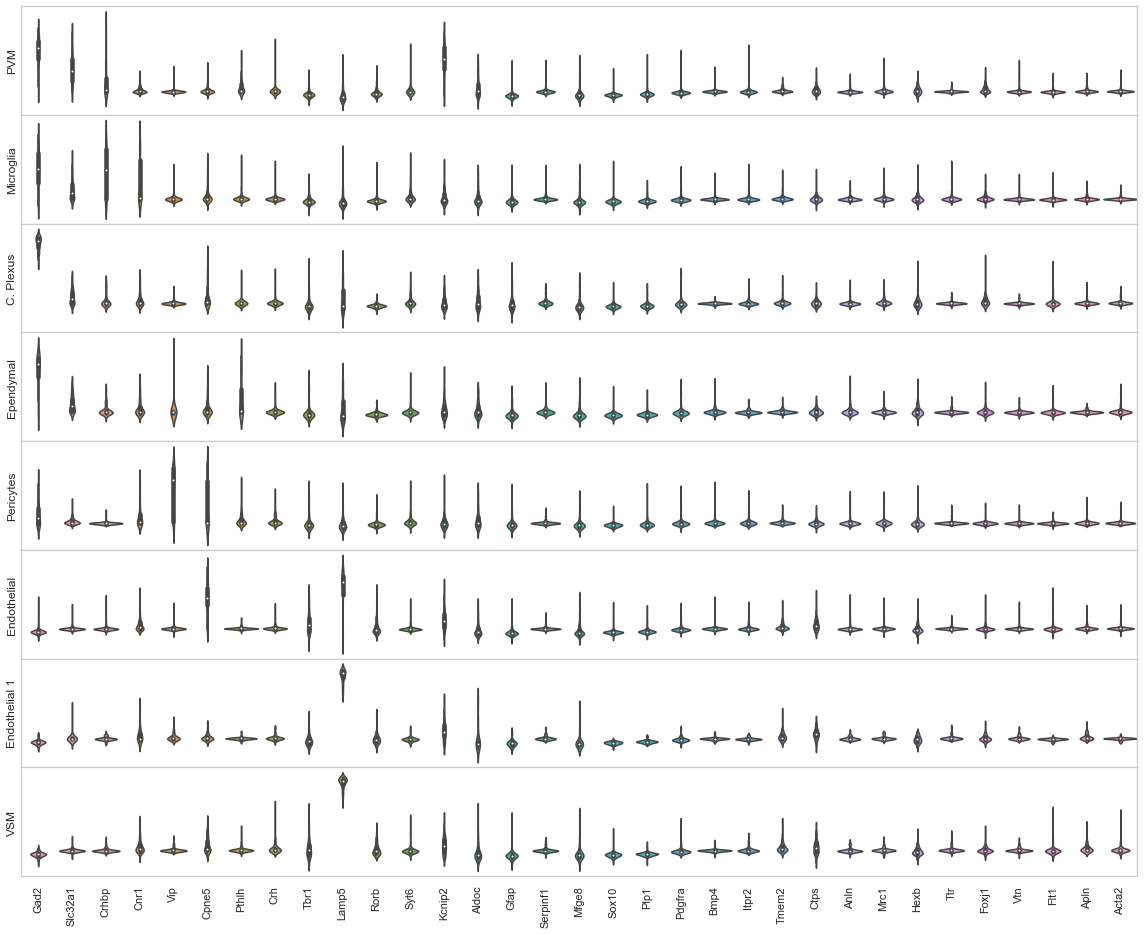

In [43]:
s = 22
e = None

indices = heatmap_clusters_index[s:e]
acc_lens = acc_sizes[s:e]
ylabels = heatmap_clusters_ordered_short[s:e]

fig, axes = plt.subplots(len(indices), 1, figsize=[20, len(indices)*2])
plt.subplots_adjust(hspace=0)
for idx in range(len(indices)):
    acc_idx = np.sum(acc_lens[:idx]).astype(int)
    cl_vecs = gene_exp_heatmap.T[acc_idx:acc_idx+acc_lens[idx]]
    sns.violinplot(ax=axes[idx], data=cl_vecs, width=1)
    axes[idx].set_ylabel(ylabels[idx])
    axes[idx].set_yticks([])
axes[idx].set_xticklabels(heatmap_genes_ordered, rotation=90)
pass

In [51]:
load_tsne("merged")

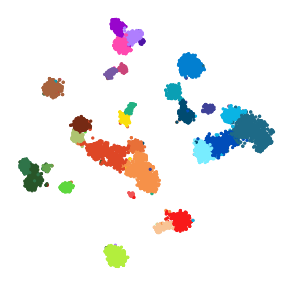

In [52]:
import matplotlib.patheffects as PathEffects
plt.figure(figsize=[5, 5])
ds.plot_tsne(pca_dims=33, metric="correlation", s=5, run_tsne=False, colors=denovo_celltype_colors)
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
plt.gca().axis('off')
pass

In [29]:
analysis.map_celltypes()
analysis.filter_celltypemaps(min_norm=filter_method, filter_params=filter_params, min_r=0.6, fill_blobs=True, min_blob_area=50)

In [36]:
plt.figure(figsize=[20, 30])
plt.imshow()

array([-2.59162851e-02,  3.27233610e-01, -4.27451473e-02, -5.78230160e-02,
       -4.71721223e-02, -7.94852345e-02, -7.52803760e-02, -6.57163090e-02,
       -7.72175579e-02, -1.16450013e-01, -5.46833853e-02, -2.66970161e-02,
       -1.08182814e-01,  1.19018859e+00, -9.00237341e-02, -1.58488664e-02,
       -1.91021187e-01, -2.61685797e-01,  1.38463638e-01, -1.16707948e-02,
       -8.04941297e-02,  3.68754109e-02, -6.74275819e-02, -1.01171046e-01,
        6.33518280e-06, -8.03320854e-02, -6.94957856e-02, -8.41250969e-02,
       -1.12261347e-01, -6.64900067e-02, -6.02348445e-02, -6.53633709e-02,
       -5.87455913e-02])

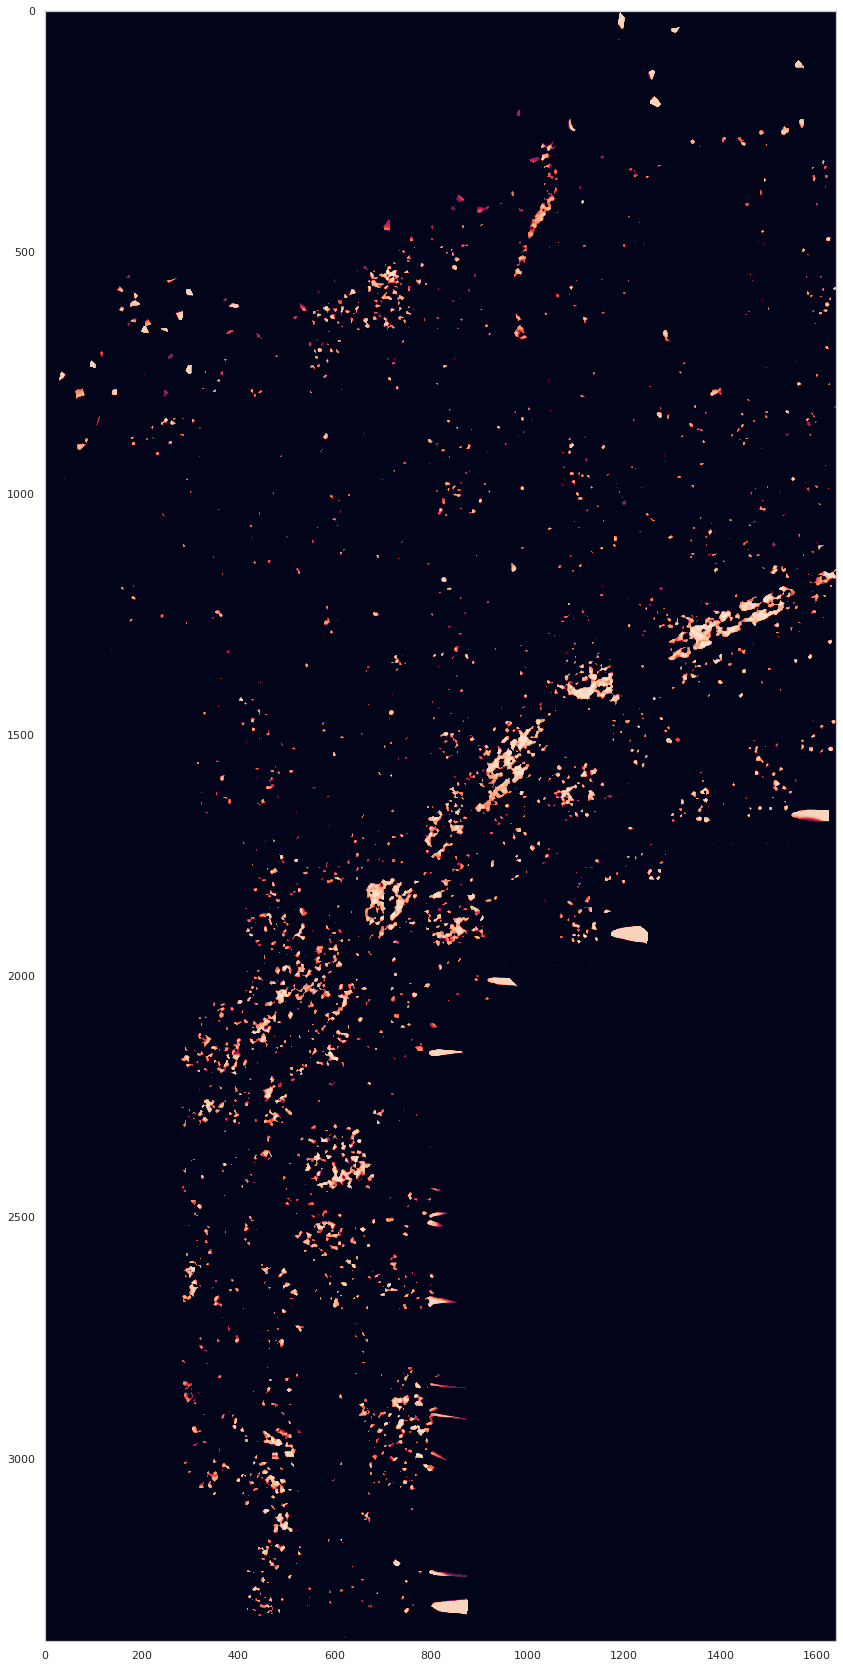

In [41]:
im = np.zeros(ds.celltype_maps.shape)
im[ds.celltype_maps == 1] = ds.max_correlations[ds.celltype_maps == 1]
plt.figure(figsize=[20, 30])
plt.imshow(im[..., 0].T)

In [210]:
lbl_bot, lbl_left, df, ms_heatmap = calc_matching_score(ds.centroids, denovo_labels_final)
df

Reference cell types                 Given cell types  \
0                    Astrocyte Gfap                   Astrocyte Gfap   
1                       Endothelial                      Endothelial   
2               Oligodendrocyte COP              Oligodendrocyte COP   
3                Oligodendrocyte NF               Oligodendrocyte NF   
4                         Microglia                        Microglia   
5                   Pyramidal Cpne5                  Pyramidal Cpne5   
6            Vascular Smooth Muscle           Vascular Smooth Muscle   
7                   Astrocyte Mfge8                  Astrocyte Mfge8   
8                      pyramidal L4                     pyramidal L4   
9                    Pyramidal L3-4                   Pyramidal L3-4   
10                Inhibitory Kcnip2                 Inhibitory Pthlh   
11                 Inhibitory Crhbp                 Inhibitory Crhbp   
12                Pyramidal L2-3 L5                Pyramidal L2-3 L5   
13  Oligodendrocyte Precursor cells  Oligodendrocyte Precursor cells   
14                        Pericytes                        Pericytes   
15                    Inhibitory IC                  Inhibitory Rest   
16                     Pyramidal L6                     Pyramidal L6   
17           Oligodendrocyte Mature           Oligodendrocyte Mature   
18               Oligodendrocyte MF               Oligodendrocyte MF   
19                        Ependymal                        Ependymal   
20                   Pyramidal L2-3                   Pyramidal L2-3   
21                  Inhibitory Cnr1                  Inhibitory Cnr1   
22                    Inhibitory CP                Inhibitory Kcnip2   
23                      Hippocampus                      Hippocampus   

    Pearson's r  Matched segments  Total segments  Matching score  
0          0.96                77              81            0.95  
1          0.96               144             235            0.61  
2          0.98               108             142            0.76  
3          0.97                56              76            0.74  
4          0.93                49              52            0.94  
5          0.95                55              76            0.72  
6          0.93                 5              31            0.16  
7          0.94               107             119            0.90  
8          0.97               400             483            0.83  
9          0.95               106             138            0.77  
10         0.80                29              83            0.35  
11         0.96               102             120            0.85  
12         0.98               282             288            0.98  
13         0.98               102             111            0.92  
14         0.84                21              94            0.22  
15         0.95                64              78            0.82  
16         0.96               388             400            0.97  
17         0.97               341             381            0.90  
18         0.98                87              97            0.90  
19         0.98                95             107            0.89  
20         0.97               138             172            0.80  
21         0.97                30              40            0.75  
22         0.82                95             161            0.59  
23         0.93                98             133            0.74

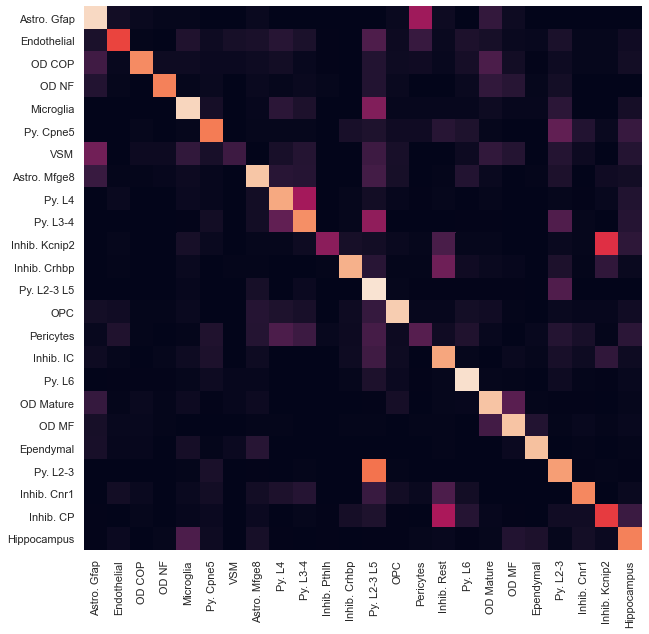

In [40]:
plt.figure(figsize=[10, 10])
sns.heatmap(ms_heatmap,
            yticklabels=shorten_labels(lbl_left),
            xticklabels=shorten_labels(lbl_bot), cbar=False, vmin=0, vmax=1)
pass

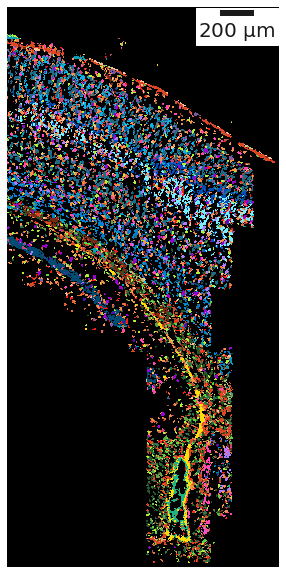

In [129]:
plt.figure(figsize=[5, 10.3])
ds.plot_celltypes_map(colors=denovo_celltype_colors, rotate=1, set_alpha=False)

scalebar = ScaleBar(1, 'um', pad=0.2, font_properties={"size": 20})
plt.gca().add_artist(scalebar)

plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
sns.despine(top=True, bottom=True, left=True, right=True)

plt.show()

In [226]:
denovo_labels_final

['Astrocyte Gfap',
 'Perivascular Macrophages',
 'Endothelial',
 'Oligodendrocyte COP',
 'Oligodendrocyte NF',
 'Microglia',
 'Endothelial 1',
 'Astrocyte Aldoc',
 'Pyramidal Cpne5',
 'Inhibitory Vip',
 'Vascular Smooth Muscle',
 'Pyramidal L5',
 'Astrocyte Mfge8',
 'pyramidal L4',
 'Pyramidal L3-4',
 'Inhibitory Pthlh',
 'Inhibitory Crhbp',
 'Pyramidal L2-3 L5',
 'Oligodendrocyte Precursor cells',
 'Pericytes',
 'Inhibitory Rest',
 'Pyramidal L6',
 'Oligodendrocyte Mature',
 'Oligodendrocyte MF',
 'Ependymal',
 'Pyramidal L2-3',
 'Inhibitory Cnr1',
 'Inhibitory Kcnip2',
 'Hippocampus',
 'C. Plexus']

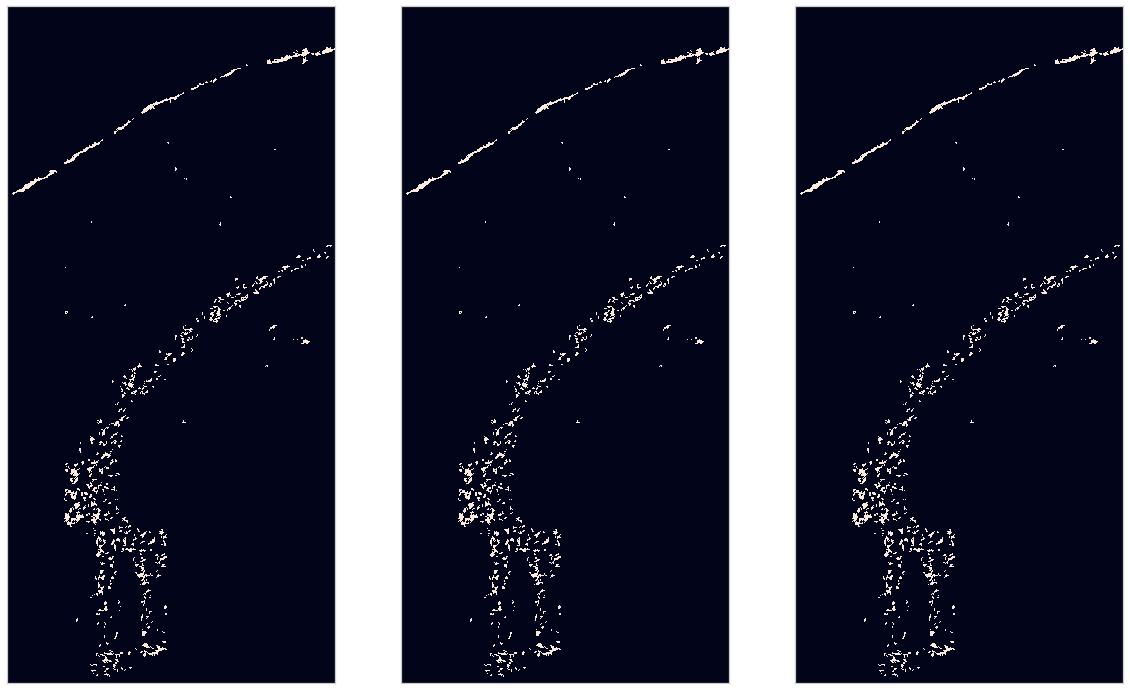

In [233]:
ms_indices = [denovo_labels_final.index(cl) for cl in df['Given cell types']]
for lbl1, lbl2 in zip(df['Reference cell types'], df['Given cell types']):
    im1 = np.zeros([ds.vf_norm.shape[1], ds.vf_norm.shape[0], 4])
    im2 = np.zeros([ds.vf_norm.shape[1], ds.vf_norm.shape[0], 4])
    im3 = np.zeros([ds.vf_norm.shape[1], ds.vf_norm.shape[0], 4])

    idx1 = osmfish_uniq_labels.index(lbl1)
    idx2 = denovo_labels_final.index(lbl2)
    
    mask1 = seg_map.T == idx1
    mask2 = ds.filtered_celltype_maps[..., 0].T == idx2

    im1[np.logical_and(mask1, ~mask2)] = (0, 0, 1, 1)
    im1[np.logical_and(~mask1, mask2)] = (1, 0, 0, 1)
    im1[np.logical_and(mask1, mask2)] = (1, 1, 1, 1)
    
    plt.figure(figsize=[20, 30])
    ax = plt.subplot(1, 3, 1)
    ax.imshow(im1)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax = plt.subplot(1, 3, 2)
    ax.imshow(ds.filtered_celltype_maps[..., 0].T == idx)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax = plt.subplot(1, 3, 3)
    ax.imshow(ds.filtered_celltype_maps[..., 0].T == idx)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    break

In [189]:
import pandas as pd
from scipy.spatial.distance import cdist

def calc_matching_score(centroids, uniq_labels):
    m_corrs = cdist(centroids, osmfish_centroids, ssam.utils.corr)
    max_mask = m_corrs > 0.8
    max_mask &= m_corrs == m_corrs.max(axis=0)
    max_mask &= (m_corrs.T == m_corrs.max(axis=1)).T
    x, y = np.where(max_mask)
    high_corr_labels_bot = np.array(uniq_labels)[x]
    high_corr_labels_left = np.array(osmfish_uniq_labels)[y]

    hm_total = np.zeros([len(x), len(centroids)], dtype=int)
    hm = np.zeros([len(x), len(centroids)])

    for i, idx in enumerate(y):
        cell_indices = np.unique(seg_map[seg_ctmap == idx])
        hm_total[i, :] = len(cell_indices)
        for j in cell_indices:
            ssam_seg = ds.celltype_maps[..., 0][seg_map == j]
            ssam_cts, ssam_ctcnts = np.unique(ssam_seg, return_counts=True)
            ssam_ctfreqs = ssam_ctcnts / len(ssam_seg)
            hm[i, ssam_cts] += (ssam_ctfreqs > 0.1).astype(int)
    ms = (hm / hm_total)[:, x]
    df = pd.DataFrame({
        "Reference cell types": np.array(osmfish_uniq_labels)[y],
        "Given cell types": np.array(uniq_labels)[x],
        "Pearson's r": np.round(m_corrs[x, y], 2),
        "Matched segments": np.diag(hm[:, x].astype(int)),
        "Total segments": np.diag(hm_total[:, x]),
        "Matching score": np.round(np.diag(ms), 2),
    })
    return high_corr_labels_bot, high_corr_labels_left, df, ms

NameError: name 'df' is not defined

In [188]:
cts = ["C. Plexus", ""]
denovo_labels_final.index("C. Plexus")

29

In [80]:
osmfish_uniq_labels_ordered = [
    'Inhibitory CP',
    'Inhibitory Crhbp',
    'Inhibitory Cnr1',
    'Inhibitory IC',
    'Inhibitory Kcnip2',
    'Inhibitory Pthlh',
    'Inhibitory Vip',
    'Pyramidal Cpne5',
    'Pyramidal L2-3',
    'Pyramidal L2-3 L5',
    'Pyramidal L3-4',
    'pyramidal L4',
    'Pyramidal Kcnip2',
    'Pyramidal L5',
    'Pyramidal L6',
    'Hippocampus',
    'Astrocyte Gfap',
    'Astrocyte Mfge8',
    'Oligodendrocyte Precursor cells',
    'Oligodendrocyte COP',
    'Oligodendrocyte NF',
    'Oligodendrocyte MF',
    'Oligodendrocyte Mature',
    'Perivascular Macrophages',
    'Microglia',
    'C. Plexus',
    'Ependymal',
    'Pericytes',
    'Endothelial',
    'Endothelial 1',
    'Vascular Smooth Muscle',
]
scrna_uniq_labels_ordered = [
    'Int1',
    'Int2',
    'Int3',
    'Int4',
    'Int5',
    'Int6',
    'Int7',
    'Int8',
    'Int9',
    'Int10',
    'Int11',
    'Int12',
    'Int13',
    'Int14',
    'Int15',
    'Int16',
    'CA1PyrInt',
    'PyrL23',
    'PyrL4',
    'PyrL5',
    'PyrL5a',
    'PyrL6',
    'PyrL6b',
    'SubPyr',
    'PyrDL',
    'CA1Pyr1',
    'CA1Pyr2',
    'CA2Pyr2',
    'ClauPyr',
    'Astro1',
    'Astro2',
    'OPC',
    'COP',
    'NFOL1',
    'NFOL2',
    'MFOL1',
    'MFOL2',
    'MOL1',
    'MOL2',
    'MOL3',
    'MOL4',
    'MOL5',
    'MOL6',
    'Pvm1',
    'Pvm2',
    'Mgl1',
    'Mgl2',
    'Choroid',
    'Epend',
    'Peric',
    'Vend1',
    'Vend2',
    'Vsmc',
    'Vlmc',
]

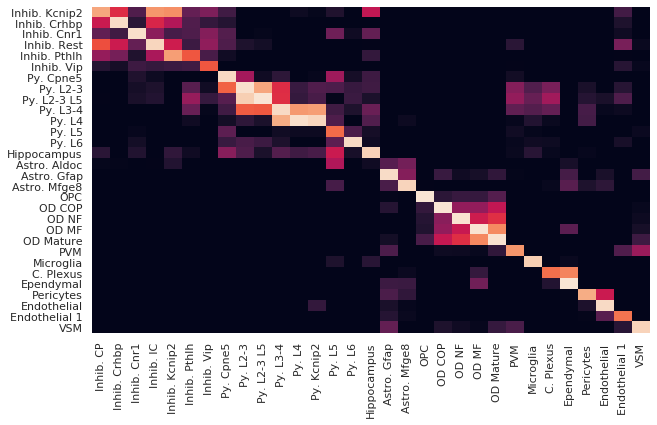

In [81]:
osmfish_uniq_labels_index = [osmfish_uniq_labels.index(i) for i in osmfish_uniq_labels_ordered]

dcs = np.array(ds.centroids)[heatmap_clusters_index]
ocs = osmfish_centroids[osmfish_uniq_labels_index]

centroids_corr = np.zeros([len(osmfish_centroids), len(ds.centroids)])
for i, oc in enumerate(ocs):
    for j, dc in enumerate(dcs):
        centroids_corr[i, j] = ssam.utils.corr(oc, dc)

plt.figure(figsize=[10, 6])
sns.heatmap(centroids_corr.T,
            yticklabels=shorten_labels(heatmap_clusters_ordered),
            xticklabels=shorten_labels(osmfish_uniq_labels_ordered), cbar=False, vmin=0, vmax=1)
#plt.ylabel("SSAM clusters")
#plt.xlabel("osmFISH clusters")

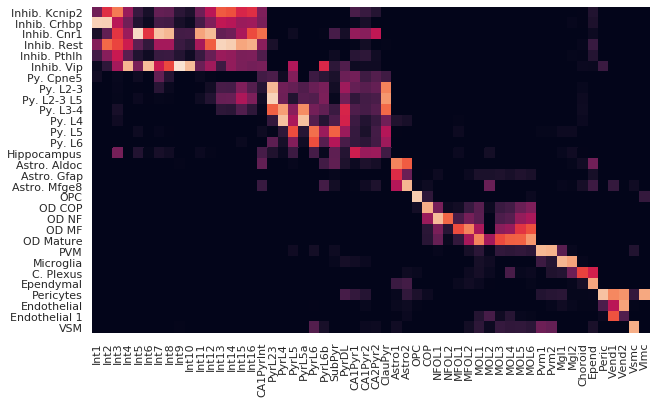

In [82]:
scrna_uniq_labels_stripped = ["Vlmc" if cl == "PPR" else (cl[2:] if cl[:2] == "S1" else cl) for cl in scrna_uniq_labels]
scrna_uniq_labels_index = [scrna_uniq_labels_stripped.index(i) for i in scrna_uniq_labels_ordered]

dcs = np.array(ds.centroids)[heatmap_clusters_index]
scs = scrna_centroids[scrna_uniq_labels_index]

centroids_corr = np.zeros([len(scrna_centroids), len(ds.centroids)])
for i, sc in enumerate(scs):
    for j, dc in enumerate(dcs):
        centroids_corr[i, j] = ssam.utils.corr(sc, dc)

plt.figure(figsize=[10, 6])
sns.heatmap(centroids_corr.T,
            yticklabels=shorten_labels(heatmap_clusters_ordered),
            xticklabels=shorten_labels(scrna_uniq_labels_ordered), cbar=False, vmin=0, vmax=1)
#plt.ylabel("SSAM clusters")
#plt.xlabel("scRNA clusters")

In [47]:
analysis.bin_celltypemaps(step=10, radius=100)

In [48]:
analysis.find_domains(n_clusters=15, merge_remote=False, merge_thres=0.6, norm_thres=4500)

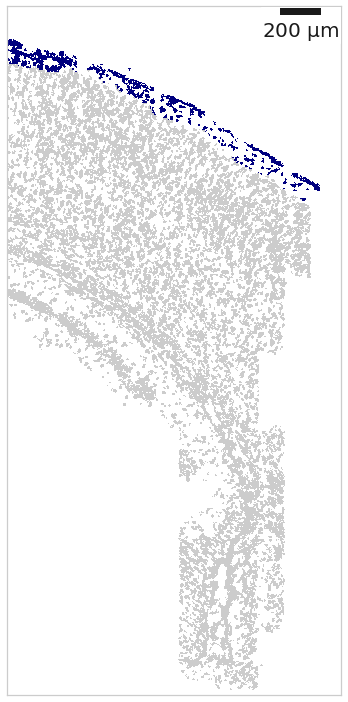

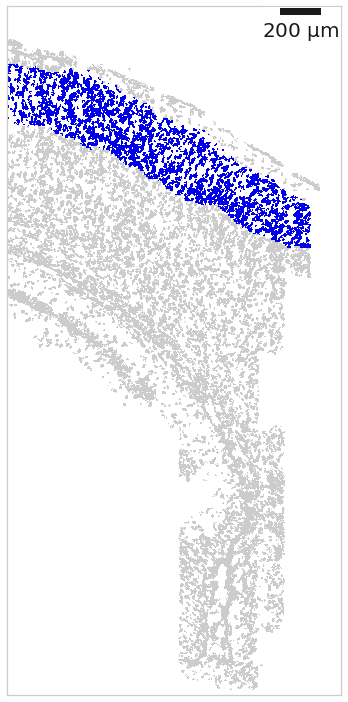

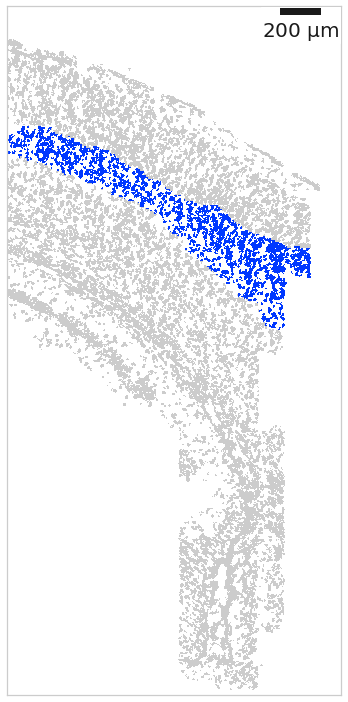

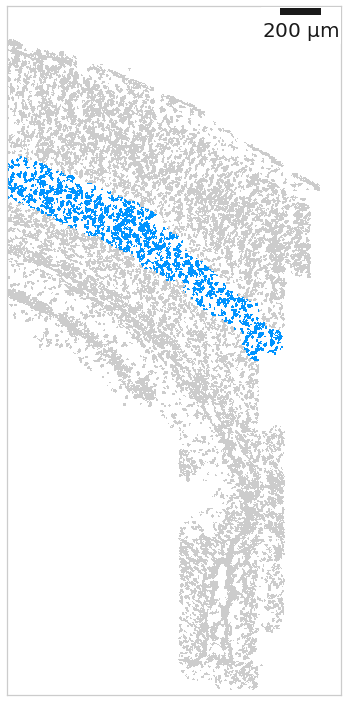

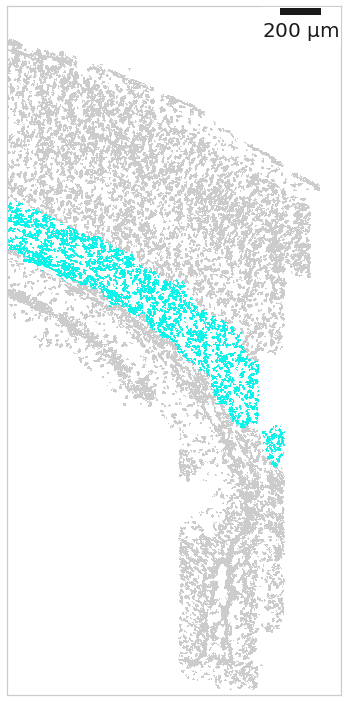

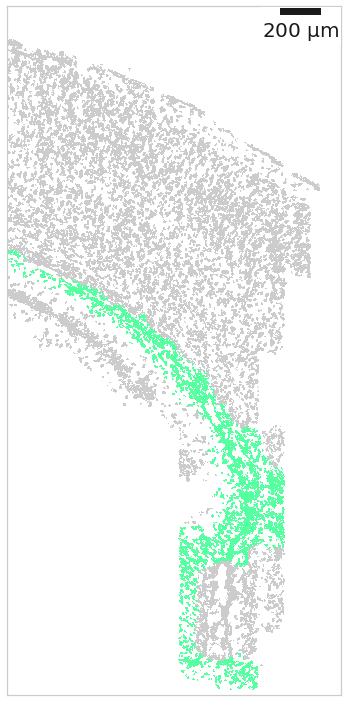

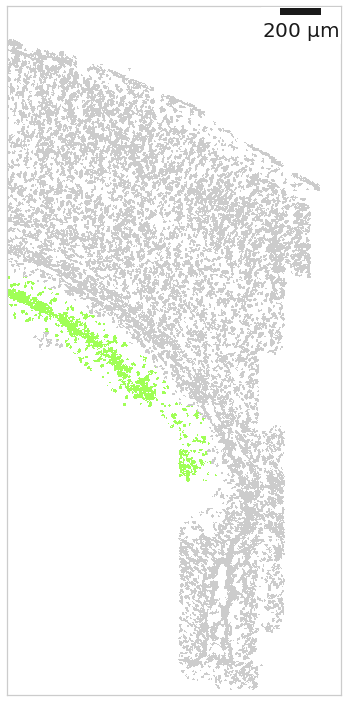

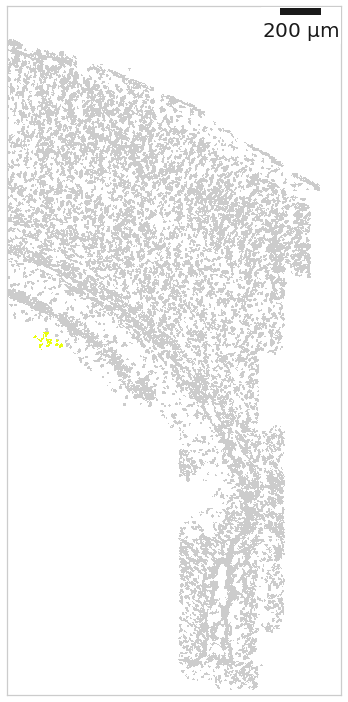

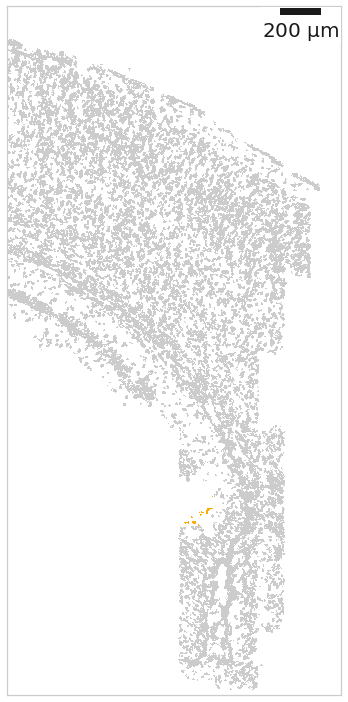

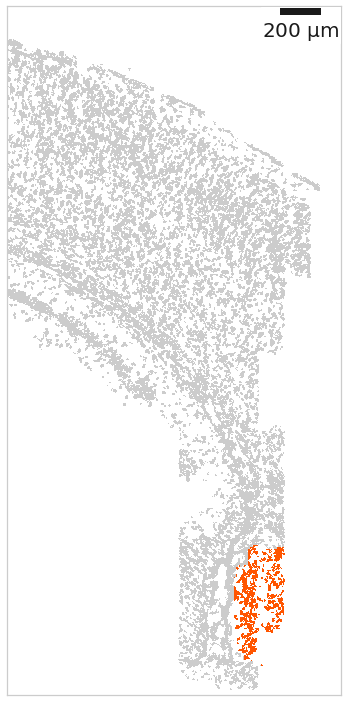

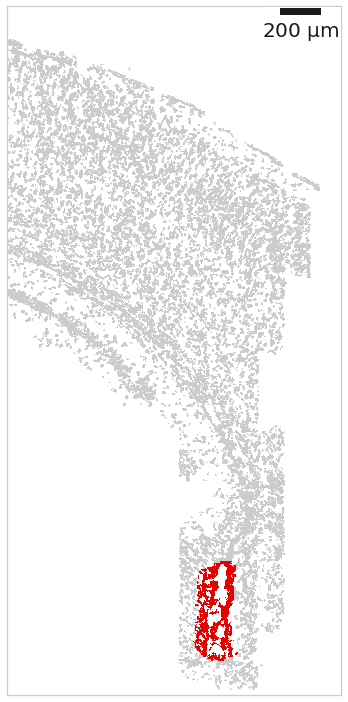

In [134]:
# Check found domains
from matplotlib.colors import ListedColormap
cmap_jet = plt.get_cmap('jet')
num_domains = np.max(ds.inferred_domains_cells) + 1
for domain_idx in range(num_domains):
    plt.figure(figsize=[5, 10.3])
    cmap = ListedColormap([cmap_jet(lbl_idx / num_domains) if domain_idx == lbl_idx else "#cccccc" for lbl_idx in range(num_domains)])
    ds.plot_domains(rotate=1, cmap=cmap)
    scalebar = ScaleBar(1, 'um', pad=0.1, font_properties={"size": 20})
    plt.gca().add_artist(scalebar)
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    plt.tight_layout()

In [54]:
domain_colors = {
    'Pia+Layer 1': '#D44218',
    'Layer 2/3': '#85D7E4',
    'Layer 4': '#F6B813',
    'Layer 5': '#C6271B',
    'Layer 6': '#4987B9',
    'White matter': '#58BC06',
    'Hippocampus': '#104368',
    'Ventricle': '#F4D527',
    'IC CP': '#9C2387',
}

In [50]:
excluded_domain_indices = []
merged_domain_indices = [[5, 7, 8], ]

In [51]:
analysis.exclude_and_merge_domains(excluded_domain_indices, merged_domain_indices)

In [52]:
domain_labels = [
    'Pia+Layer 1',
    'Layer 2/3',
    'Layer 4',
    'Layer 5',
    'Layer 6',
    'White matter',
    'Hippocampus',
    'IC CP',
    'Ventricle',
]

(1639.5, -0.5, 3379.5, -0.5)

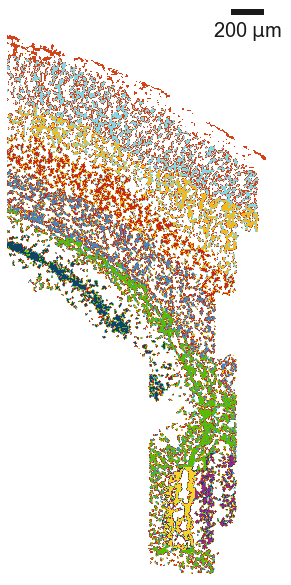

In [55]:
from matplotlib.colors import ListedColormap
plt.figure(figsize=[5, 10.5])
cmap = ListedColormap([domain_colors[lbl] for lbl in domain_labels])
ds.plot_domains(rotate=1, cmap=cmap)

scalebar = ScaleBar(1, 'um', pad=0.1, font_properties={"size": 20})
plt.gca().add_artist(scalebar)
plt.axis('off')

In [56]:
analysis.calc_cell_type_compositions()

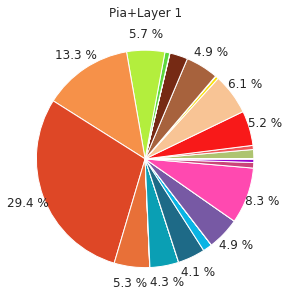

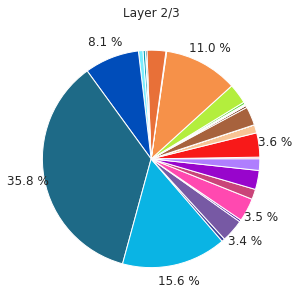

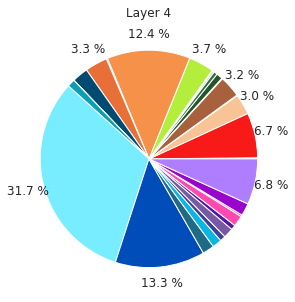

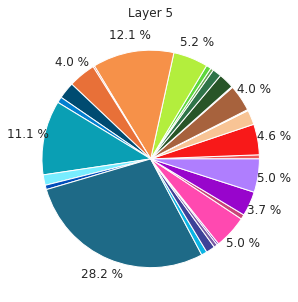

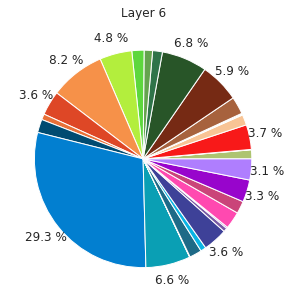

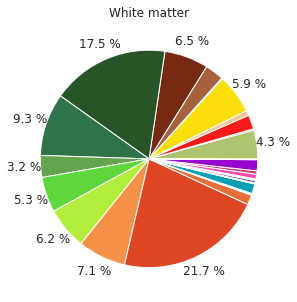

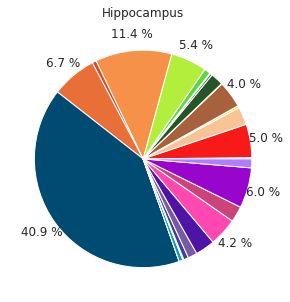

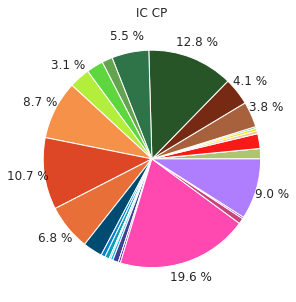

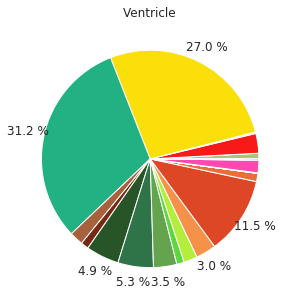

In [144]:
# We updated our algorithm, and below result is slightly
# different from the published one

for domain_idx in [0, 1, 2, 3, 4, 5, 6, 7, 8]:
    plt.figure(figsize=[5, 5])
    ds.plot_celltype_composition(domain_idx,
                                 cell_type_colors=denovo_celltype_colors,
                                 cell_type_orders=heatmap_clusters_index[::-1],
                                 label_cutoff=0.03)
    plt.title(domain_labels[domain_idx])

Text(0.5, 1.0, 'All')

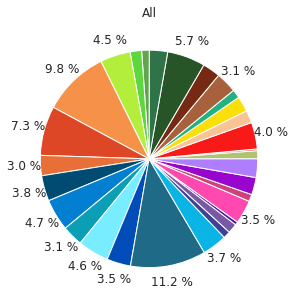

In [145]:
plt.figure(figsize=[5, 5])
ds.plot_celltype_composition(domain_index=9,
                             cell_type_colors=denovo_celltype_colors,
                             cell_type_orders=heatmap_clusters_index[::-1],
                             label_cutoff=0.03)
plt.title('All')

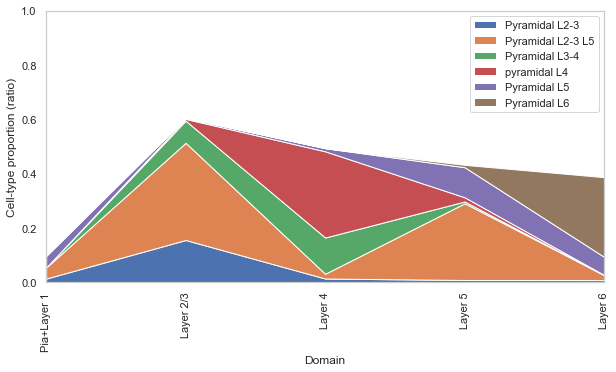

In [65]:
plt.figure(figsize=[10, 5])
indices = heatmap_clusters_index[7:13]
x = range(5)
y = ds.inferred_domains_compositions[:5, indices].T
plt.stackplot(x, y, labels=np.array(denovo_labels_final)[indices])
plt.xticks(range(len(domain_labels[:5])), labels=domain_labels[:5], rotation=90)
plt.xlabel("Domain")
plt.ylabel("Cell-type proportion (ratio)")
plt.xlim([0, 4])
plt.ylim([0, 1])
plt.legend()
#plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
pass

## Reproduce original result in Codeluppi *et al*.

In [198]:
with open("zenodo/osmFISH/raw_data/polyT_seg.pkl", "rb") as f:
    seg_dic = pickle.load(f)

In [201]:
#seg_clusternames = list(np.unique(osmfish_loom.col_attrs["ClusterName"]))

cell_ids = []
cell_clusters = []
for cell_id, cl in zip(osmfish_loom.col_attrs['CellID'], osmfish_loom.col_attrs["ClusterName"]):
    if cl == 'Excluded':
        continue
    cell_ids.append(cell_id)
    cell_clusters.append(cl)
col_dic = dict(zip(cell_ids, [osmfish_ref_colors.get(e) for e in cell_clusters]))
clid_dic = dict(zip(cell_ids, [osmfish_uniq_labels.index(e) for e in cell_clusters]))

In [202]:
from matplotlib.colors import to_rgba

seg_img = np.zeros([ds.shape[0], ds.shape[1], 4])
seg_img[..., 3] = 1 # background color to black
seg_map = np.zeros([ds.shape[0], ds.shape[1]], dtype=int)
seg_ctmap = np.zeros([ds.shape[0], ds.shape[1]], dtype=int) - 1
for cell_idx, (cell_id, seg_coords) in enumerate(seg_dic.items(), start=1):
    if not cell_id in cell_ids:
        continue
    seg_coords_small = (seg_coords / pixel_per_um).astype(int)
    seg_col = to_rgba(col_dic[cell_id])
    seg_ctmap[seg_coords_small[:, 0], seg_coords_small[:, 1]] = clid_dic[cell_id]
    seg_map[seg_coords_small[:, 0], seg_coords_small[:, 1]] = int(cell_id)
    seg_img[seg_coords_small[:, 0], seg_coords_small[:, 1]] = seg_col

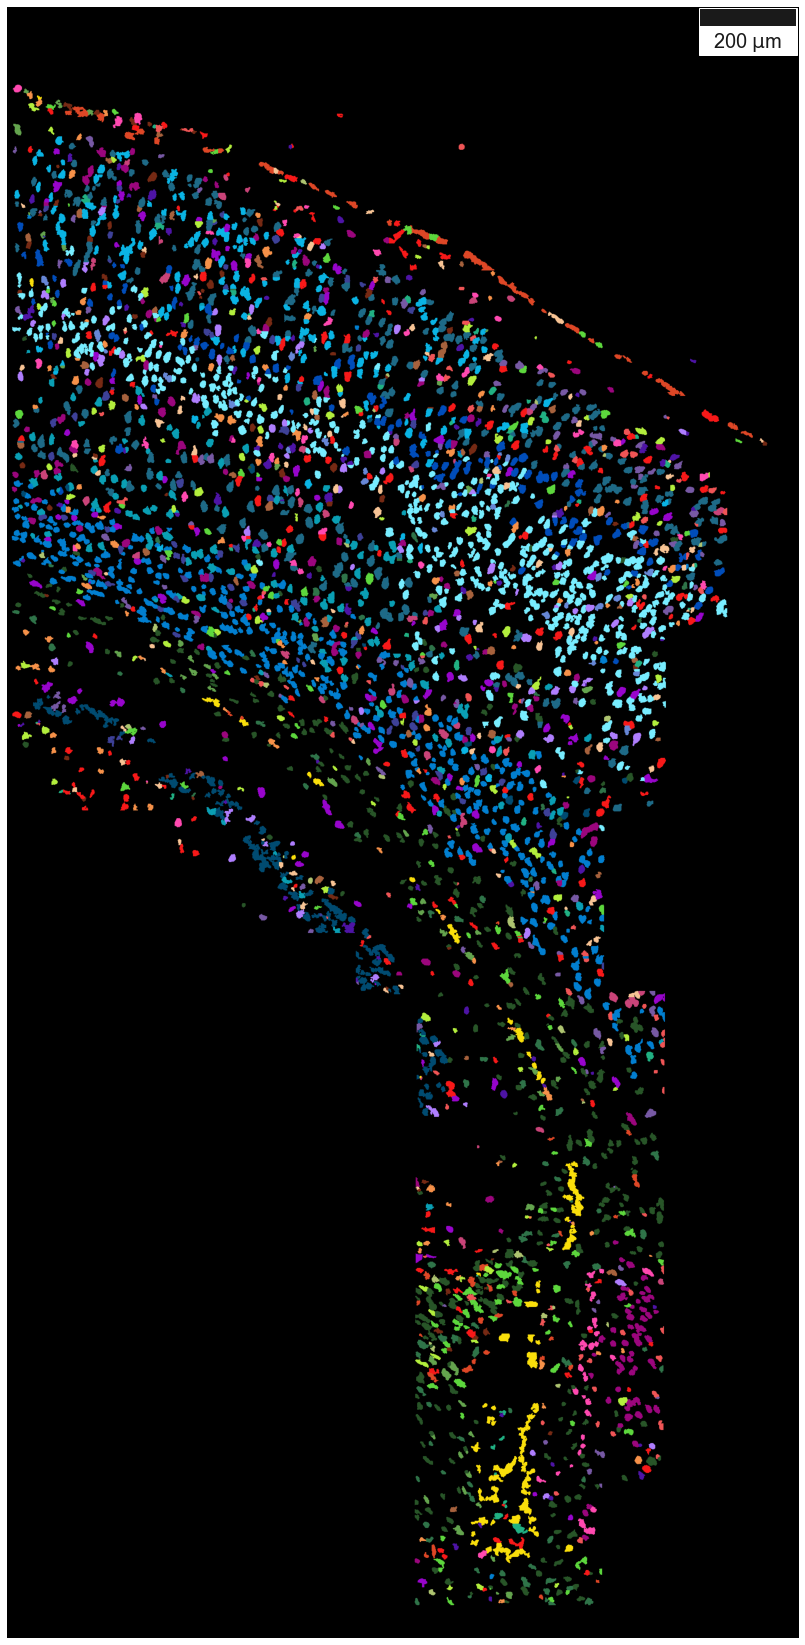

In [71]:
plt.figure(figsize=[20, 30])
plt.imshow(seg_img.swapaxes(0, 1))
plt.xlim([ds.shape[0], 0])
scalebar = ScaleBar(1, 'um', pad=0.1, font_properties={"size": 20})
plt.gca().add_artist(scalebar)
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
sns.despine(top=True, bottom=True, left=True, right=True)
pass

In [70]:
common_clusters = ["Oligodendrocyte COP", "Oligodendrocyte Mature", "Endothelial", "pyramidal L4", "Pyramidal Cpne5",
                   "Pericytes", "Vascular Smooth Muscle", "Inhibitory Crhbp", "Pyramidal L3-4", "Oligodendrocyte MF",
                   "Pyramidal L2-3 L5", "Astrocyte Mfge8", "Pyramidal L2-3", "Inhibitory Cnr1", "Pyramidal L6",
                   "Hippocampus", "Ependymal", "Microglia", "Oligodendrocyte Precursor cells", "Oligodendrocyte NF",
                   "Astrocyte Gfap", ]

In [81]:
import scipy
import pandas as pd

vfn = ds.normalized_vf.reshape(-1, len(ds.genes))
df = pd.DataFrame(columns=['Part', 'Correlations', 'Cell Type'])
for cl in common_clusters:
    mask_1 = seg_ctmap == list(seg_clusternames).index(cl)
    mask_2 = ds.filtered_celltype_maps[..., 0] == list(denovo_labels_final).index(cl)
    
    intersection = np.logical_and(mask_1, mask_2)
    osmfish_only = np.logical_and(mask_1, np.logical_and(mask_1, ~mask_2))
    ssam_only    = np.logical_and(mask_2, np.logical_and(mask_2, ~mask_1))
    if cl == 'Astrocyte Mfge8':
        break
    
    if np.sum(intersection) == 0:
        print("No overlap in %s"%cl)
        continue
        
    mean_exp_intersection = np.mean(vfn[np.ravel(intersection)], axis=0)
    corrs = scipy.spatial.distance.cdist([mean_exp_intersection], vfn[np.ravel(ssam_only)], metric=ssam.utils.corr)[0]
    df = df.append(
        pd.DataFrame(zip(*[
            ["SSAM"]*len(corrs),
            corrs,
            [cl]*len(corrs),
        ]), columns=['Part', 'Correlations', 'Cell Type']))
    
    corrs = scipy.spatial.distance.cdist([mean_exp_intersection], vfn[np.ravel(osmfish_only)], metric=ssam.utils.corr)[0]
    df = df.append(
        pd.DataFrame(zip(*[
            ["osmFISH"]*len(corrs),
            corrs,
            [cl]*len(corrs),
        ]), columns=['Part', 'Correlations', 'Cell Type']))

df["Cell Type"] = shorten_labels(df["Cell Type"])

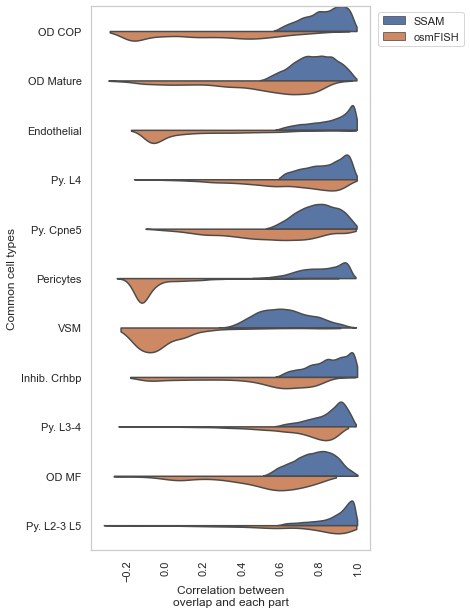

In [84]:
plt.figure(figsize=[5, 10])
sns.violinplot(y="Cell Type", x="Correlations", hue="Part", data=df, width=1, cut=0, scale="area", split=True, inner=None)
#plt.title("Pixel-wise correlations between segment overlap and segment parts per cell type")
plt.xlabel("Correlation between\noverlap and each part")
plt.ylabel("Common cell types")
plt.xticks(rotation=90)
plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
pass

In [103]:
len(ds.centroids), len(denovo_labels_final)

(31, 30)

## Gene expression of Mfge8 vs Astrocyte Mfge8

In [150]:
with open('zenodo/osmFISH/raw_data/im_nuc_small.pickle', 'rb') as f:
    dapi = pickle.load(f)
with open('zenodo/osmFISH/raw_data/im_polya_small.pickle', 'rb') as f:
    polya = pickle.load(f)

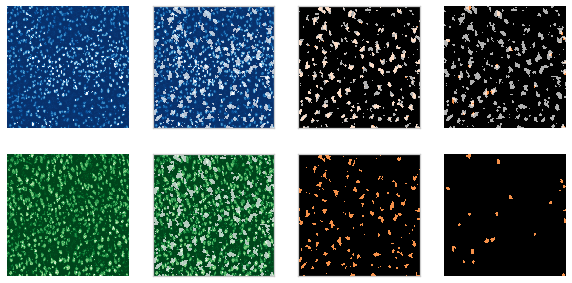

In [152]:
x = slice(1000, 1500)
y = slice(500, 1000)

thres = 0.1

#from skimage.filters import threshold_otsu
gene_exp = ds.vf[x, y, 0, ds.genes.index('Mfge8')].T
#thres = threshold_otsu(gene_exp) - np.std(gene_exp) / 1.5
gene_im = np.zeros([x.stop - x.start, y.stop - y.start, 4])
gene_im[gene_exp > thres] = [1, 1, 1, 0.7]

plt.figure(figsize=[10, 5])
ax = plt.subplot(2, 4, 1)
plt.imshow(dapi[y, x], cmap='Blues_r')
plt.clim([0, 0.004])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.axis('off')

ax = plt.subplot(2, 4, 2)
plt.imshow(dapi[y, x], cmap='Blues_r')
plt.clim([0, 0.004])
plt.imshow(gene_im)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(2, 4, 3)
ds.plot_celltypes_map(colors=denovo_celltype_colors, rotate=1, set_alpha=False, centroid_indices=[
    denovo_labels_final.index("Astrocyte Mfge8"),
])
gene_im2 = np.zeros_like(seg_img)
gene_im2[y, x] = gene_im
plt.imshow(gene_im2)
plt.xlim([x.start, x.stop])
plt.ylim([y.stop, y.start])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(2, 4, 4)
seg_img2 = np.array(seg_img, copy=True)
seg_img2[seg_ctmap != seg_clusternames.index("Astrocyte Mfge8")] = [0, 0, 0, 1]
plt.imshow(seg_img2[x, y].swapaxes(0, 1))
plt.imshow(gene_im)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.axis('off')

ax = plt.subplot(2, 4, 5)
plt.imshow(polya[y, x], cmap='Greens_r')
plt.clim([0, 0.03])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.axis('off')

ax = plt.subplot(2, 4, 6)
plt.imshow(polya[y, x], cmap='Greens_r')
plt.clim([0, 0.03])
plt.imshow(gene_im)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)


ax = plt.subplot(2, 4, 7)
ds.plot_celltypes_map(colors=denovo_celltype_colors, rotate=1, set_alpha=False, centroid_indices=[
    denovo_labels_final.index("Astrocyte Mfge8"),
])
plt.xlim([x.start, x.stop])
plt.ylim([y.stop, y.start])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(2, 4, 8)
seg_img2 = np.array(seg_img, copy=True)
seg_img2[seg_ctmap != seg_clusternames.index("Astrocyte Mfge8")] = [0, 0, 0, 1]
plt.imshow(seg_img2[x, y].swapaxes(0, 1))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.axis('off')

pass

## Ventricle structure

In [ ]:
x = slice(380, 780)
y = slice(2650, 3300)

plt.figure(figsize=[10, 12])
ax = plt.subplot(3, 4, 1)
plt.imshow(dapi[y, x], cmap='Blues_r')
plt.clim([0, 0.004])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.axis('off')

ax = plt.subplot(3, 4, 2)
plt.imshow(polya[y, x], cmap='Greens_r')
plt.clim([0, 0.03])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.axis('off')

ax = plt.subplot(3, 4, 3)
ds.plot_celltypes_map(colors=denovo_celltype_colors, rotate=1, set_alpha=False)
plt.xlim([x.start, x.stop])
plt.ylim([y.stop, y.start])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(3, 4, 4)
plt.imshow(seg_img.swapaxes(0, 1))
plt.xlim([x.start, x.stop])
plt.ylim([y.stop, y.start])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.axis('off')

ax = plt.subplot(3, 4, 5)
plt.imshow(ds.vf[x, y, 0, ds.genes.index('Foxj1')].T, cmap='Reds_r')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.axis('off')

ax = plt.subplot(3, 4, 6)
plt.imshow(ds.vf[x, y, 0, ds.genes.index('Ttr')].T, cmap='Purples_r')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.axis('off')

ax = plt.subplot(3, 4, 7)
ds.plot_celltypes_map(colors=denovo_celltype_colors, rotate=1, set_alpha=False, centroid_indices=[
    denovo_labels_final.index("Ependymal"),
    denovo_labels_final.index("C. Plexus")
])
plt.xlim([x.start, x.stop])
plt.ylim([y.stop, y.start])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(3, 4, 8)
seg_img2 = np.array(seg_img, copy=True)
seg_img2[np.logical_and(
    seg_ctmap != seg_clusternames.index("Ependymal"),
    seg_ctmap != seg_clusternames.index("C. Plexus"),
)] = [0, 0, 0, 1]
plt.imshow(seg_img2.swapaxes(0, 1))
plt.xlim([x.start, x.stop])
plt.ylim([y.stop, y.start])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.axis('off')
pass